# Machine Learning for Cyber Attack Detection

## Introduction

In this notebook, we aim to develop a machine learning model to detect cyber attacks using a high-dimensional dataset. The process involves several key steps:

1. **Data Loading and Preprocessing**:
    - Load the training and testing data.
    - Check the shape and inspect for any missing values.

2. **Align Train and Test Features, Data Normalization**
    - Align the commom data between the training and testing datasets
    - Normalize the data to ensure all features contribute equally to the model.

3. **Exploratory Data Analysis (EDA)**:
    - Analyze the distribution of labels to understand the class imbalance.
    - Apply techniques such as PCA to assess the variance explained by the features.

4. **Feature Engineering**:
    - Generate polynomial and interaction features to capture non-linear relationships.
    - Evaluate the impact of these features on model performance and decide on the final feature set.

5. **Handling Class Imbalance**:
    - Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution.
    - Adjust class weights in the models to handle the imbalance.

6. **Model Training and Hyperparameter Tuning**:
    - Initialize multiple machine learning models (Random Forest, SVM, and Ensemble).
    - Define hyperparameter grids for each model and perform hyperparameter tuning using RandomizedSearchCV.
    - Evaluate model performance using cross-validation and select the best-performing models.

7. **Model Evaluation and Comparison**:
    - Compare the performance metrics (accuracy, precision, recall, and F1 score) of the models.
    - Analyze training times to understand the computational efficiency of each model.

8. **Final Model Training and Predictions**:
    - Train the final model on the entire training dataset using SMOTE.
    - Generate predictions on the test dataset and save the results.

### 0. Import necessary libraries


In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from itertools import combinations

### 1. Load the Data, Check its shape and Check for Missing Values

In [2]:
# Load the training and testing data from CSV files
train_data = pd.read_csv(r'./data/train_data.csv')
test_data = pd.read_csv(r'./data/test_data.csv')
train_labels = pd.read_csv(r'./data/train_labels.csv')

# Print the shape of the data to understand the dimensions of the dataset
print(f'train_data shape: {train_data.shape}')
print(f'train_labels shape: {train_labels.shape}')
print(f'test_data shape: {test_data.shape}')

# Check for missing values in the datasets to ensure data quality
missing_train_data = train_data.isnull().sum().sum()
missing_train_labels = train_labels.isnull().sum().sum()
missing_test_data = test_data.isnull().sum().sum()

# Print the number of missing values in each dataset
print(f'Missing values in train_data: {missing_train_data}')
print(f'Missing values in train_labels: {missing_train_labels}')
print(f'Missing values in test_data: {missing_test_data}')

train_data shape: (3749, 10000)
train_labels shape: (3749, 1)
test_data shape: (1249, 10000)
Missing values in train_data: 0
Missing values in train_labels: 0
Missing values in test_data: 0


### 2. Align Train and Test Features, Data Normalization

To ensure consistency in the feature sets for model training and prediction, we need to align the columns of the training and testing datasets. This involves finding and retaining only the common columns between the two datasets. Additionally, we will normalize the data using `StandardScaler` to scale the features, which helps improve the performance of machine learning models.

In [3]:
# Align the columns by finding and retaining only the common columns between the training and testing datasets
common_columns = train_data.columns.intersection(test_data.columns)

# Keep only the common columns in both datasets to ensure consistent feature sets
train_data = train_data[common_columns]
test_data = test_data[common_columns]

# Check how many columns were retained
print(f"Number of common columns: {len(common_columns)}")

# Normalize the data to ensure all features have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

print("Data normalization completed.")

Number of common columns: 47
Data normalization completed.


### 3. Check the Distribution of Labels

Before proceeding with model training, it's essential to understand the distribution of labels in the training data. An imbalanced dataset, where one class significantly outnumbers the other, can lead to biased models that perform poorly on the minority class. We will check the distribution of labels to identify any imbalance in the dataset.

Understanding the label distribution also helps in selecting appropriate evaluation metrics. For imbalanced datasets, metrics such as precision, recall, and the F1 score become more informative compared to accuracy.

In [4]:
# Check the distribution of labels in the training data
label_distribution = train_labels['1'].value_counts()

# Print the label distribution to understand class imbalance
print("Label distribution in training data:")
print(label_distribution)

Label distribution in training data:
 1    3374
-1     375
Name: 1, dtype: int64


**Conclusion**:
The label distribution shows that the dataset is imbalanced, with a significantly higher number of positive labels (1) compared to negative labels (-1). This imbalance can affect the model's performance, making it biased towards the majority class. 
To address this imbalance, we will need to consider resampling techniques such as SMOTE and class weight adjustment. Additionally, carefully selecting evaluation metrics like precision, recall, and F1 score will help better capture the model's performance on both classes.

### 4. Apply PCA to Reduce Dimensionality

High-dimensional data can lead to overfitting and increased computational cost. Principal Component Analysis (PCA) can help to reduce dimensionality while retaining most of the variance in the data.

To determine the optimal number of features to retain using PCA, we need to balance dimensionality reduction with information retention. Typically, we aim to keep enough principal components to explain a high percentage of the variance, around 95-99%.

By plotting the cumulative explained variance, we can visualize how many principal components are needed to retain 95% and 99% of the variance. Based on this analysis, we will decide whether to reduce the dimensionality or proceed with the original feature set.


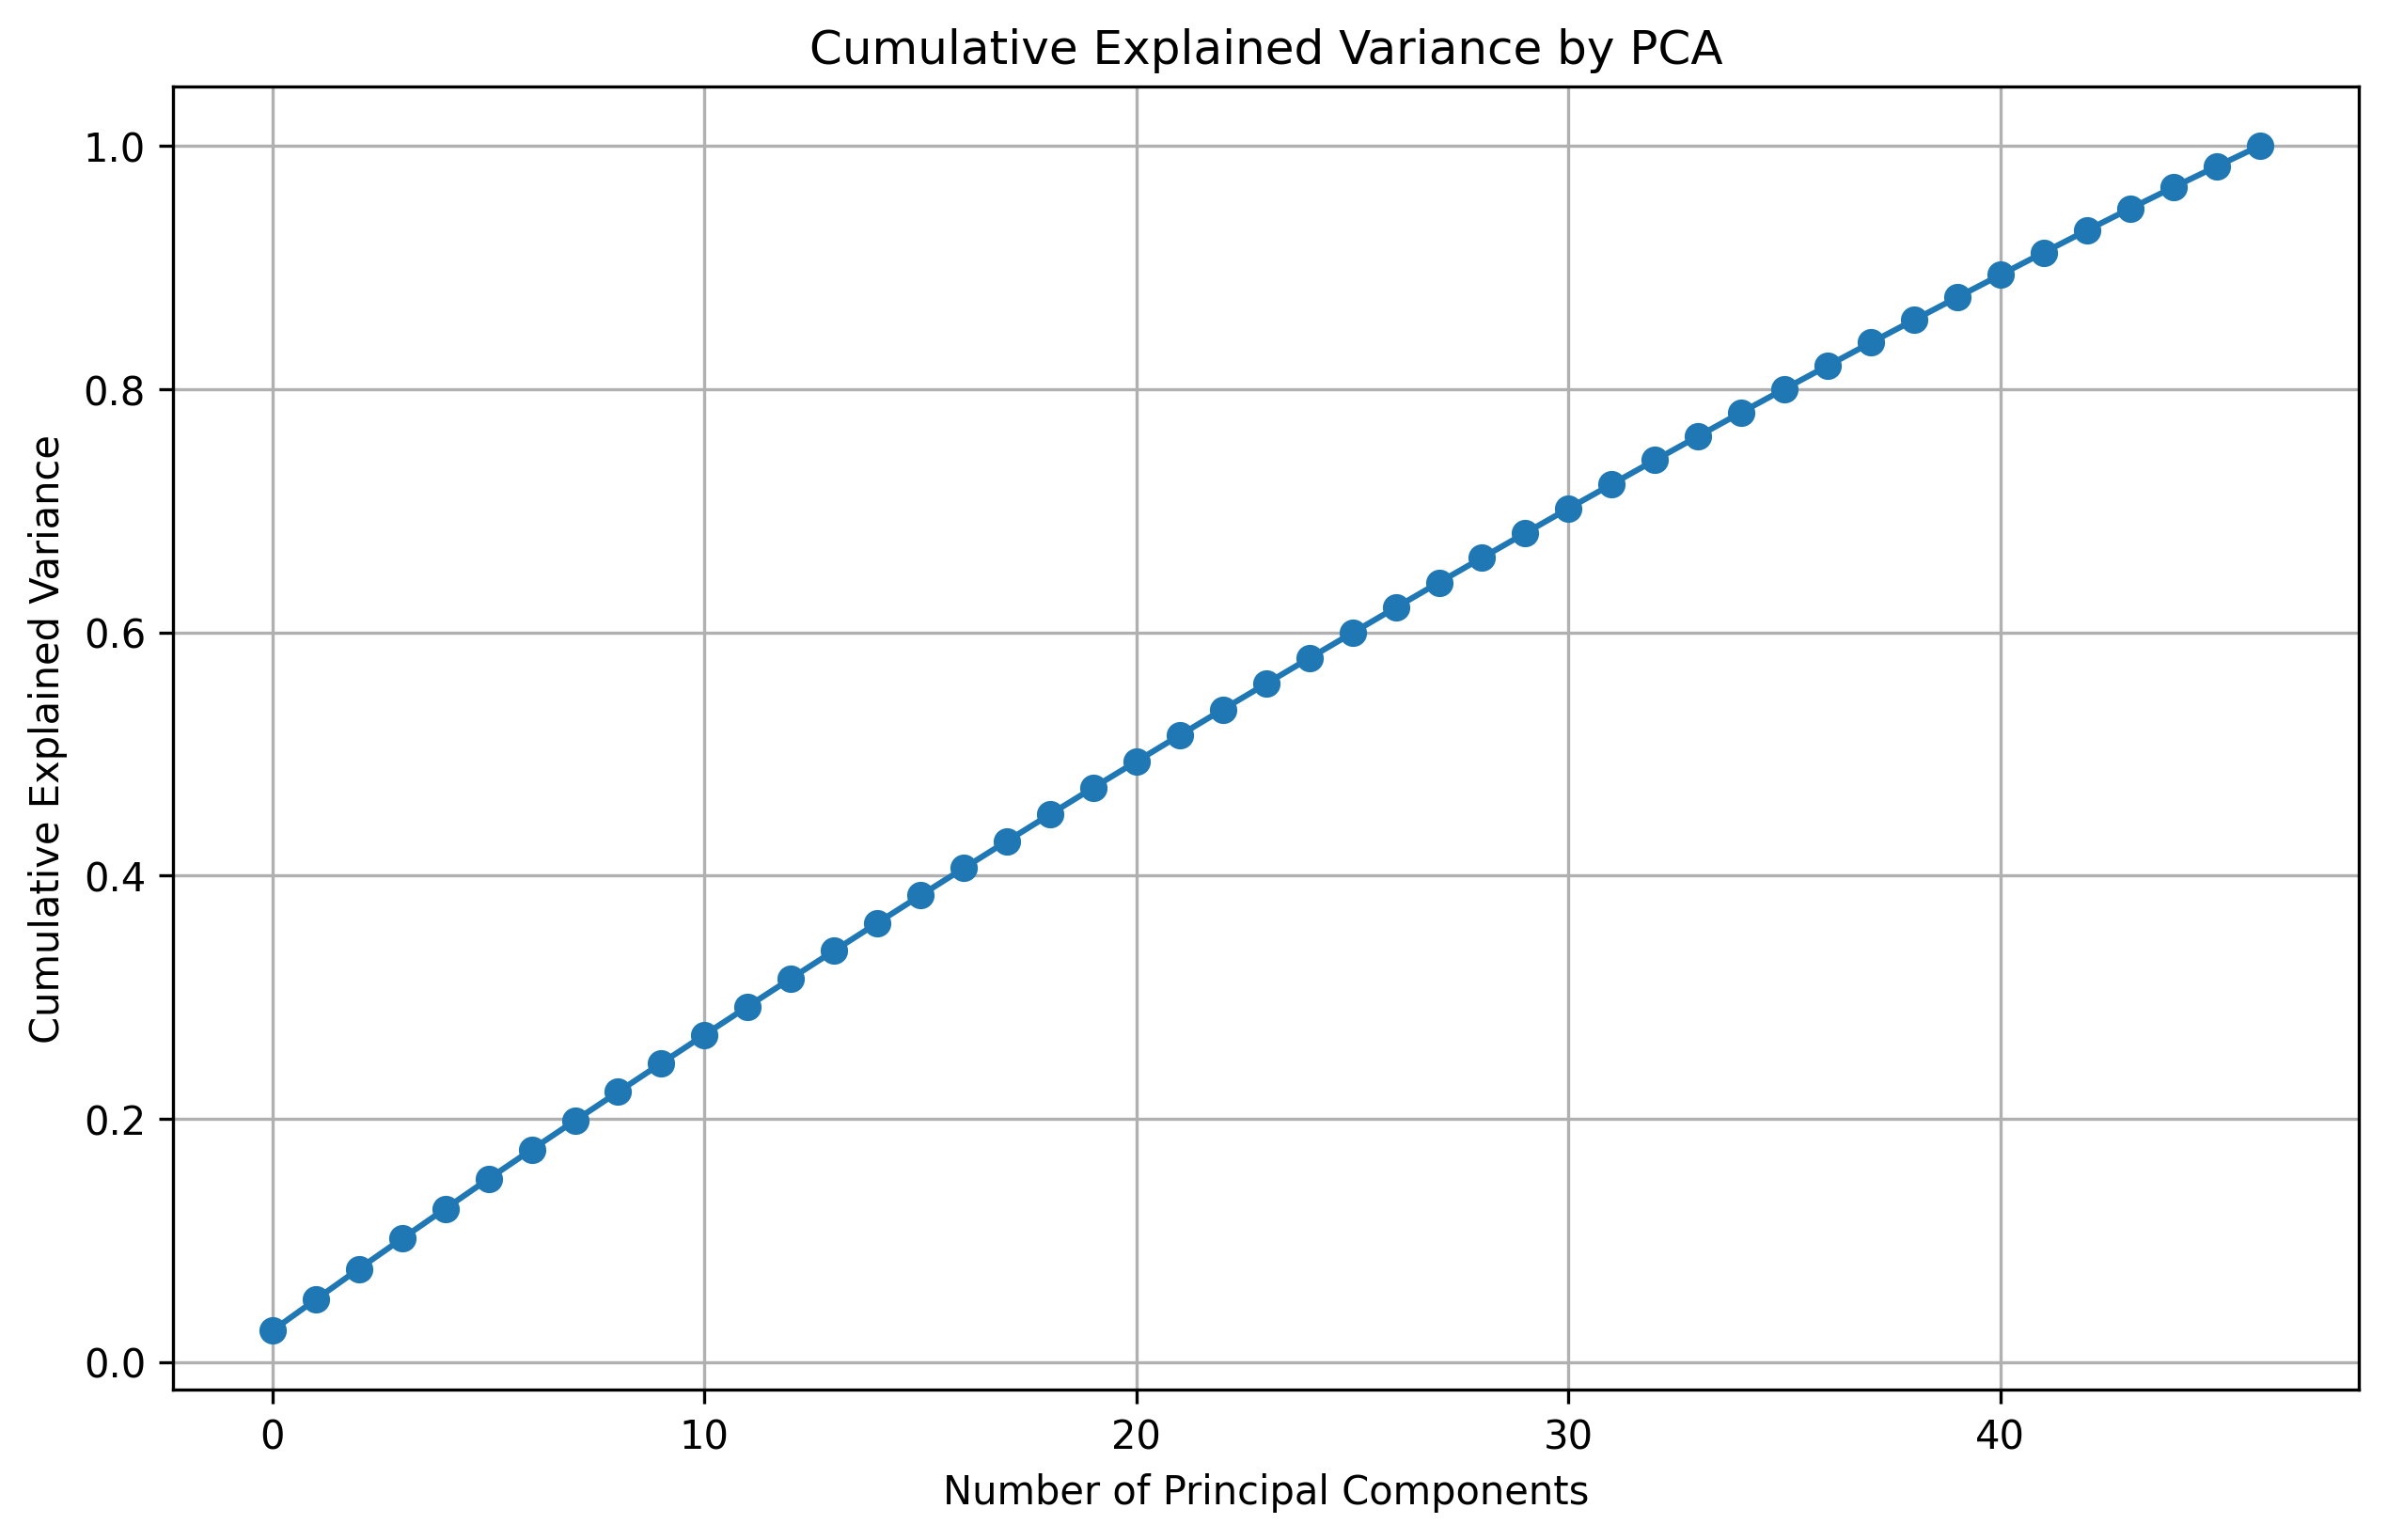

Number of components to retain 95% variance: 45
Number of components to retain 99% variance: 47


In [5]:
# Fit PCA on scaled training data
pca = PCA()
pca.fit(train_data_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()

# Determine the number of components to retain 95-99% variance
components_95 = np.argmax(cumulative_variance >= 0.95) + 1
components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f'Number of components to retain 95% variance: {components_95}')
print(f'Number of components to retain 99% variance: {components_99}')

The plot shows that 45 components are required to retain 95% of the variance and 47 components to retain 99% of the variance. Given that there is minimal reduction in the number of components while still retaining a high percentage of variance, it is reasonable to proceed without applying PCA for dimensionality reduction.

**Conclusion**:
Based on the cumulative explained variance plot, keeping all 47 features seems reasonable. Since 45 components are needed to retain 95% of the variance and 47 for 99%, reducing the number of components further might not provide significant dimensionality reduction benefits. Therefore, we will use all 47 features for model training.

### 5. Feature Engineering

Feature engineering can help improve model performance by capturing non-linear relationships in the data. We will explore two techniques: generating polynomial features and adding interaction features.

1. **Polynomial Features**: Creating new features by raising existing features to a power and creating interaction terms.
2. **Interaction Features**: Creating new features by multiplying pairs of existing features.

We will then compare these engineered features with the original features using PCA and feature importance from a Random Forest classifier. Finally, we will evaluate the model performance using cross-validation.


In [6]:
# Option 1: Polynomial Features
# Generate polynomial features to capture non-linear relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
train_data_poly = poly.fit_transform(train_data_scaled)
test_data_poly = poly.transform(test_data_scaled)

# Option 2: Adding Interaction Features
# Function to create interaction features
def create_interaction_features(data, feature_pairs):
    for (feat1, feat2) in feature_pairs:
        data[f'{feat1}_x_{feat2}'] = data[feat1] * data[feat2]
    return data

# Select pairs of features to interact (example with first 5 pairs)
selected_pairs = list(combinations(train_data.columns[:5], 2))

# Create interaction features for both train and test data
train_data_interactions = create_interaction_features(train_data.copy(), selected_pairs)
test_data_interactions = create_interaction_features(test_data.copy(), selected_pairs)

# Normalize the new datasets
scaler_interactions = StandardScaler()
train_data_interactions_scaled = scaler_interactions.fit_transform(train_data_interactions)
test_data_interactions_scaled = scaler_interactions.transform(test_data_interactions)

# Print the number of features after transformations
print(f'Original number of features: {train_data_scaled.shape[1]}')
print(f'Number of features after polynomial transformation: {train_data_poly.shape[1]}')
print(f'Number of features after adding interactions: {train_data_interactions.shape[1]}')

Original number of features: 47
Number of features after polynomial transformation: 1175
Number of features after adding interactions: 57


By generating polynomial features and interaction features, we increase the dimensionality of the data. The original dataset has a certain number of features, but polynomial and interaction transformations add significantly more features.

We need to assess whether these additional features provide any substantial benefits. To do this, we will use PCA to analyze the explained variance and Random Forest to evaluate feature importance. We will also compare model performance using cross-validation.


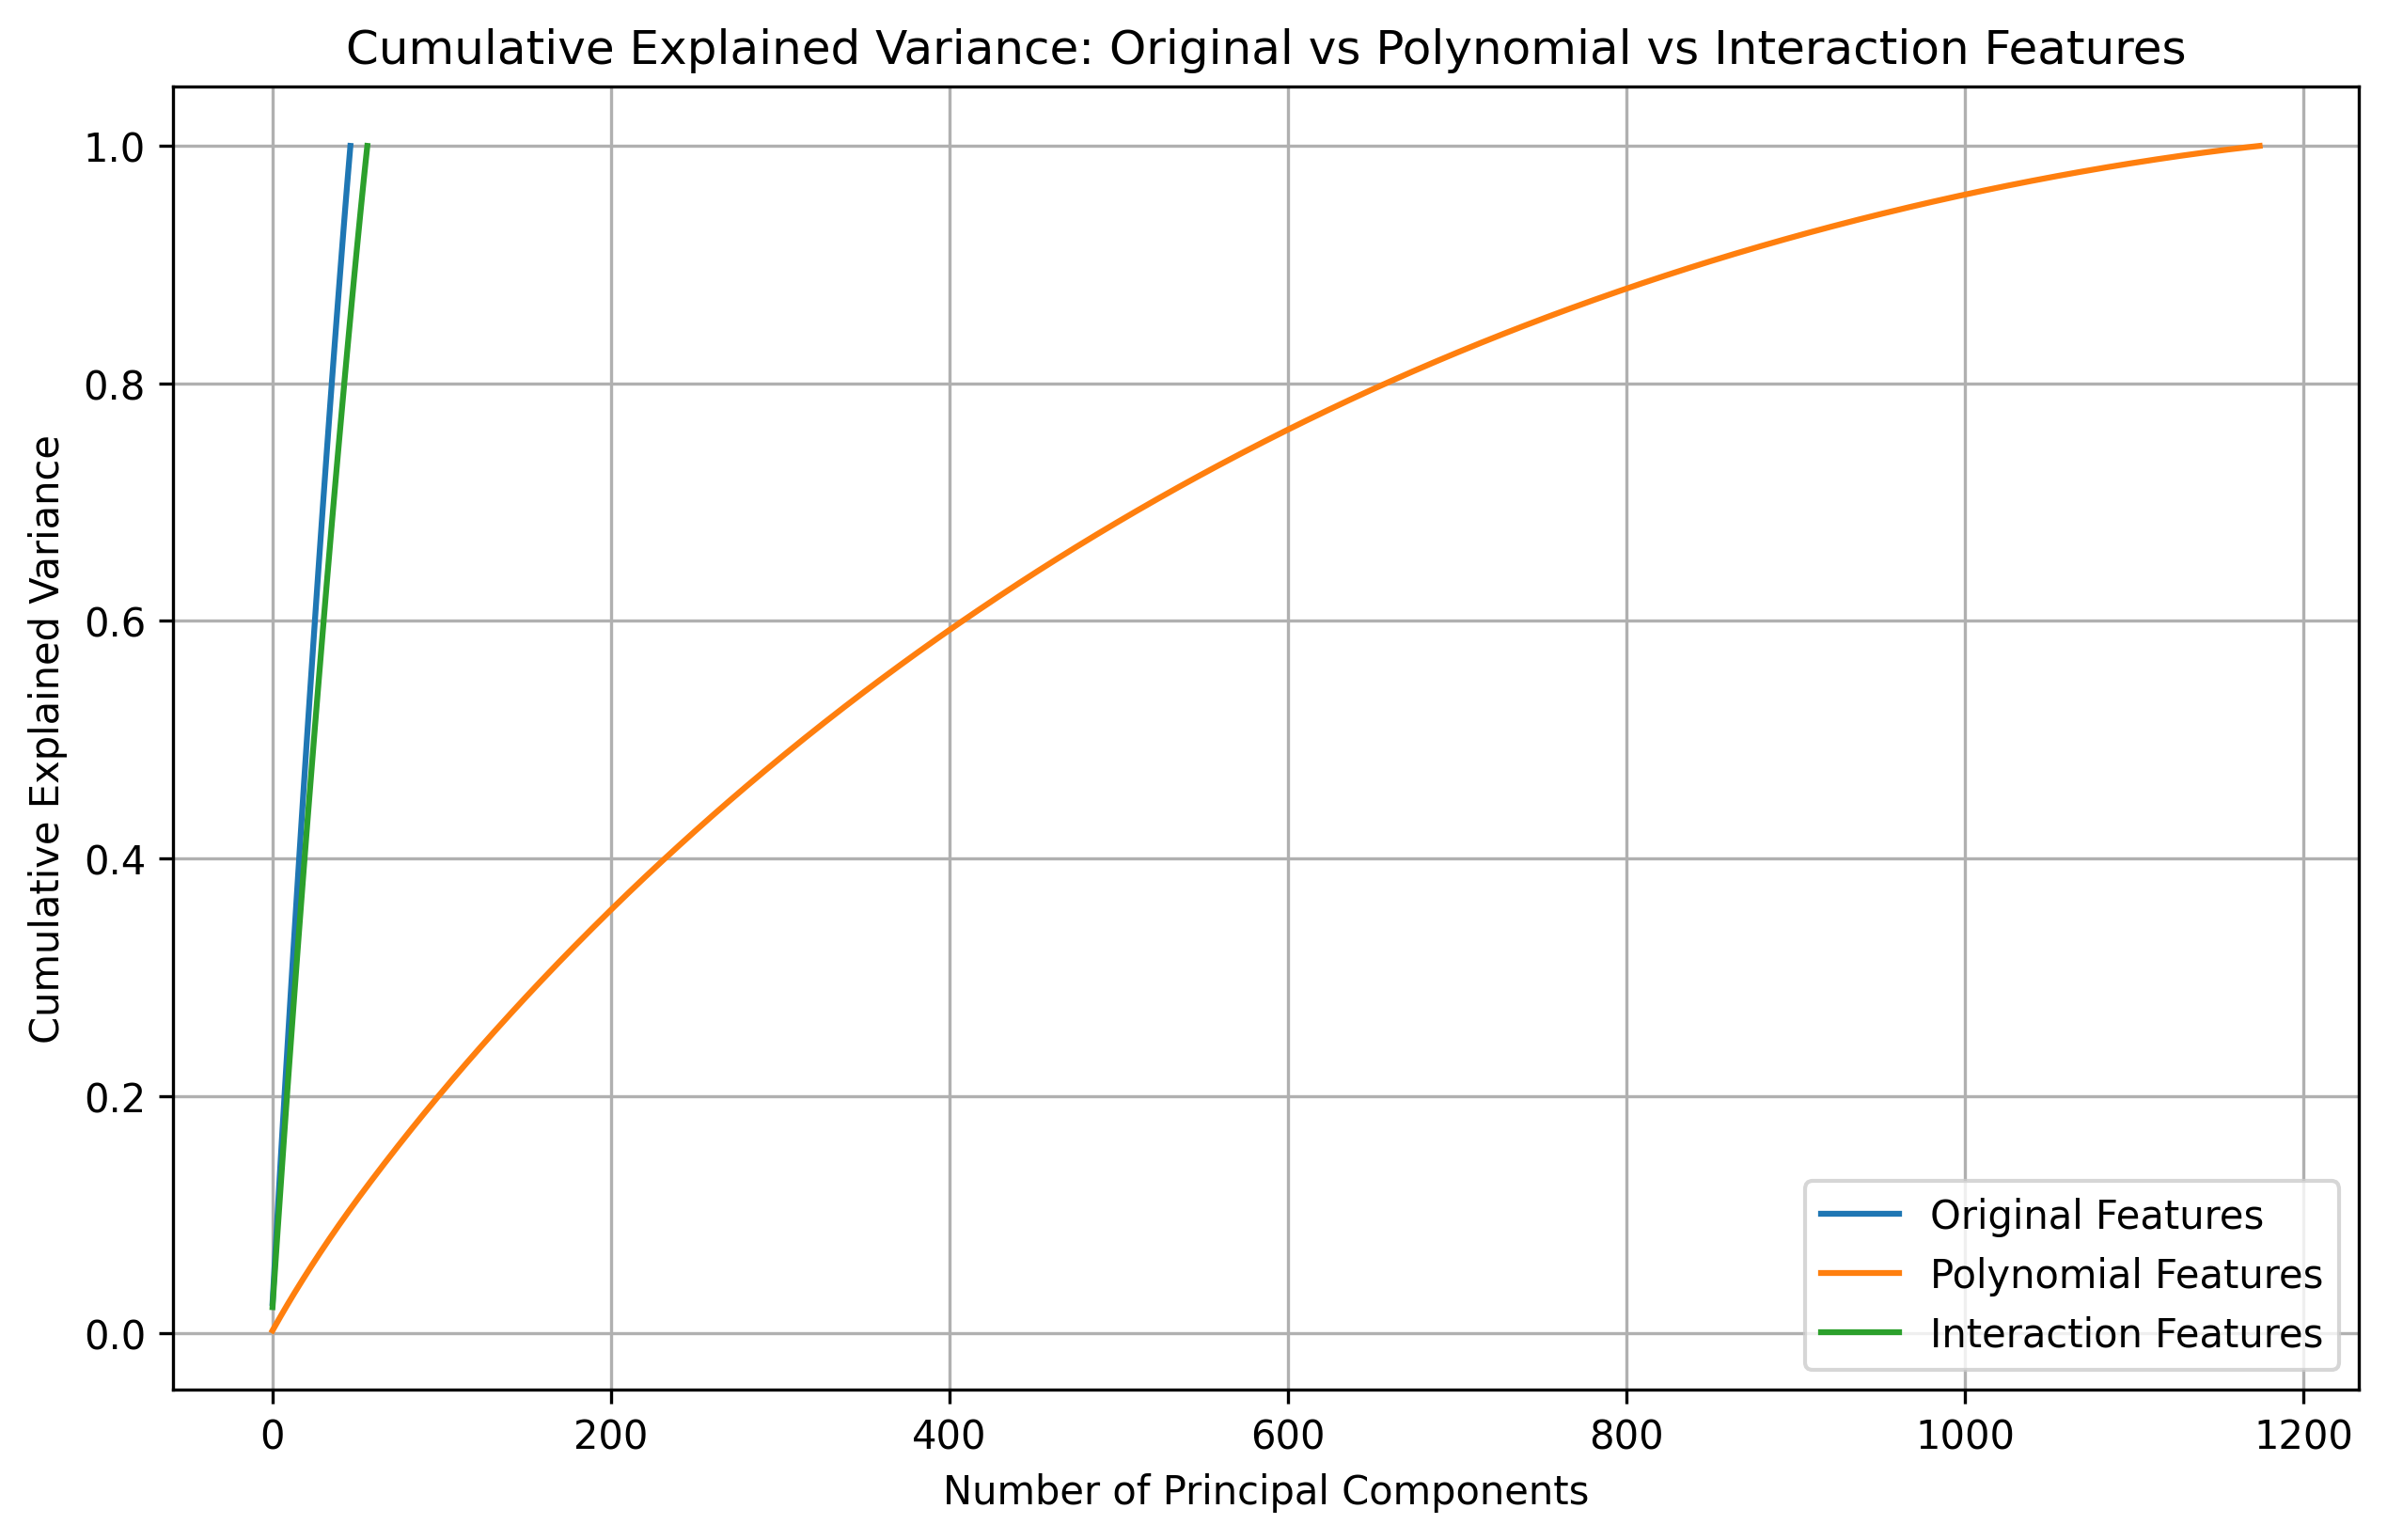

In [7]:
# Fit PCA on original scaled training data
pca_original = PCA()
pca_original.fit(train_data_scaled)
cumulative_variance_original = np.cumsum(pca_original.explained_variance_ratio_)

# Fit PCA on polynomial features
pca_poly = PCA()
pca_poly.fit(train_data_poly)
cumulative_variance_poly = np.cumsum(pca_poly.explained_variance_ratio_)

# Fit PCA on interaction features
pca_interactions = PCA()
pca_interactions.fit(train_data_interactions_scaled)
cumulative_variance_interactions = np.cumsum(pca_interactions.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(cumulative_variance_original, label='Original Features')
plt.plot(cumulative_variance_poly, label='Polynomial Features')
plt.plot(cumulative_variance_interactions, label='Interaction Features')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance: Original vs Polynomial vs Interaction Features')
plt.legend()
plt.grid(True)
plt.show()

- The **original features** achieve high cumulative explained variance with a relatively small number of principal components.
- The **polynomial features** require many more components to reach the same level of variance, indicating that they introduce a lot of additional features which may contribute to noise rather than useful information.
- The **interaction features** achieve a cumulative explained variance similar to the original features but with a slightly larger number of components. This indicates some added value but not a substantial improvement over the original features.

**Conclusion**:
- The interaction features provide a reasonable distribution of feature importance, indicating that they might add some value compared to the polynomial features, which seem to introduce a lot of noise.
- Given that the interaction features do not significantly outperform the original features in terms of explained variance, we need to assess their impact on model performance metrics before making a final decision.

Next, we will evaluate the feature importance using a Random Forest classifier and compare model performance with and without these engineered features.


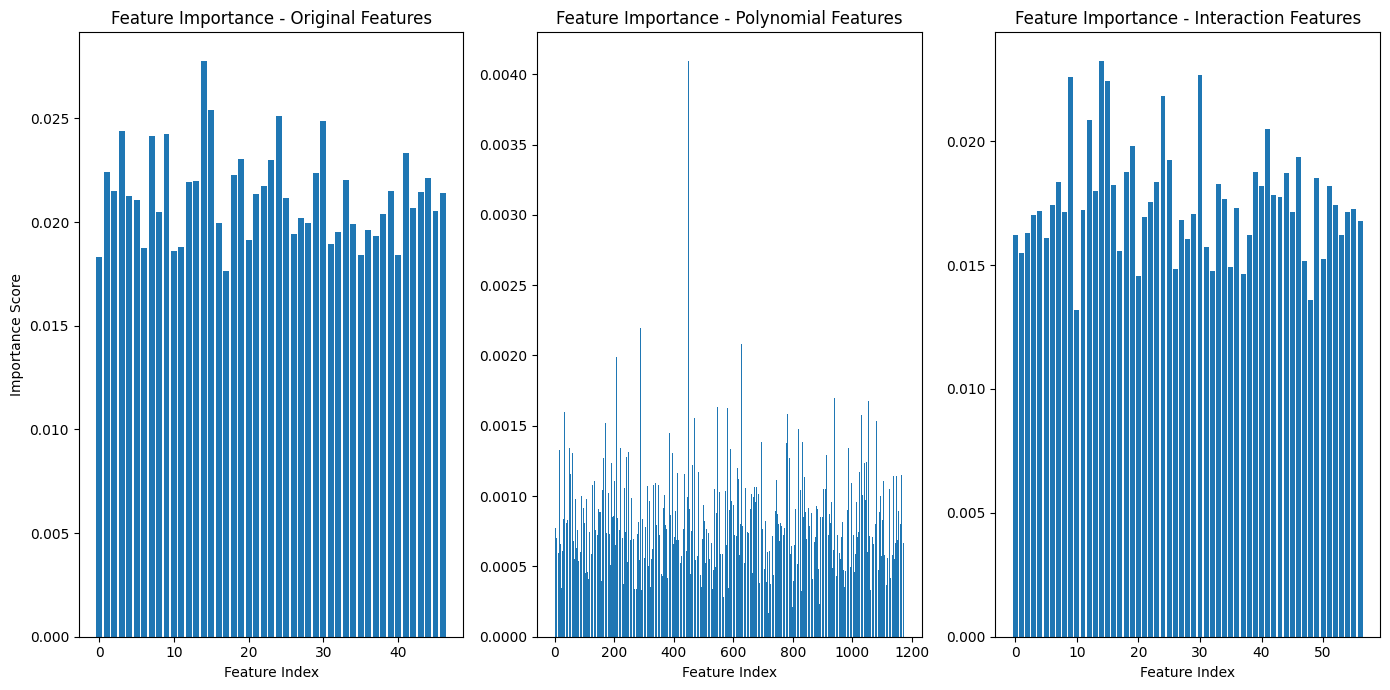

Baseline model F1 score: 0.94735
Interaction model F1 score: 0.94721
Polynomial model F1 score: 0.94721


In [8]:
# Train Random Forest on original features
rf_original = RandomForestClassifier(random_state=424)
rf_original.fit(train_data_scaled, train_labels.values.ravel())
importance_original = rf_original.feature_importances_

# Train Random Forest on polynomial features
rf_poly = RandomForestClassifier(random_state=424)
rf_poly.fit(train_data_poly, train_labels.values.ravel())
importance_poly = rf_poly.feature_importances_

# Train Random Forest on interaction features
rf_interactions = RandomForestClassifier(random_state=424)
rf_interactions.fit(train_data_interactions_scaled, train_labels.values.ravel())
importance_interactions = rf_interactions.feature_importances_

# Plot feature importances
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plt.bar(range(len(importance_original)), importance_original)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importance - Original Features')

plt.subplot(1, 3, 2)
plt.bar(range(len(importance_poly)), importance_poly)
plt.xlabel('Feature Index')
plt.title('Feature Importance - Polynomial Features')

plt.subplot(1, 3, 3)
plt.bar(range(len(importance_interactions)), importance_interactions)
plt.xlabel('Feature Index')
plt.title('Feature Importance - Interaction Features')

plt.tight_layout()
plt.show()

# Define F1 scorer
f1_scorer = make_scorer(f1_score)

# Cross-validation with F1 score on the already trained models
# Baseline model with original features
baseline_scores = cross_val_score(rf_original, train_data_scaled, train_labels.values.ravel(), cv=2, scoring=f1_scorer)

# Model with interaction features
interaction_scores = cross_val_score(rf_interactions, train_data_interactions_scaled, train_labels.values.ravel(), cv=2, scoring=f1_scorer)

# Model with polynomial features
poly_scores = cross_val_score(rf_poly, train_data_poly, train_labels.values.ravel(), cv=2, scoring=f1_scorer)

# Print the rounded F1 scores
print(f'Baseline model F1 score: {baseline_scores.mean():.5f}')
print(f'Interaction model F1 score: {interaction_scores.mean():.5f}')
print(f'Polynomial model F1 score: {poly_scores.mean():.5f}')

**Feature Importance Analysis**:

- **Original Features**: Feature importance is relatively uniform, indicating that all features contribute significantly to the model. The original features show a balanced distribution of importance scores, suggesting that each feature adds valuable information to the model.

- **Polynomial Features**: Feature importance is highly dispersed, with many features contributing very little, indicating potential noise. The polynomial features introduce a significant number of features that do not add meaningful information to the model, as evidenced by the low importance scores for most features.

- **Interaction Features**: Feature importance is slightly more dispersed than the original features but still shows a significant contribution from many features. The interaction features provide a reasonable distribution of feature importance, indicating that they might add some value compared to the polynomial features, which seem to introduce a lot of noise.

**Model Performance Analysis**:

The model performance was evaluated using cross-validation with the F1 score due to the imbalanced nature of the dataset. The F1 scores for the models are as follows:

- **Baseline model F1 score** (original features): 0.94735
- **Interaction model F1 score**: 0.94721
- **Polynomial model F1 score**: 0.94721

**Conclusion**:

- **Original Features**: The F1 score is high, and the feature importance is well-distributed, indicating that the original features are effective and should be used for the final model.
- **Interaction Features**: The F1 score is comparable to the original features, but the feature importance is slightly more dispersed. This suggests that while interaction features do not degrade performance, they do not provide significant improvement either.
- **Polynomial Features:** The F1 score is comparable to the original and interaction features. However, the feature importance plot indicates that many polynomial features do not contribute valuable information, introducing noise instead. Additionally, the number of features is much larger, leading to significantly slower computation.


**Final Decision**:
- Given the high F1 score and the well-distributed feature importance, the original features are the most efficient and effective choice for the final model. The interaction features do not offer significant performance improvement, and the polynomial features introduce unnecessary complexity and noise.

Based on this analysis, we will proceed with the original features for model training and evaluation.


### 6. Address Class Imbalance Using SMOTE and Class Weight Adjustment

To address the class imbalance, we will use two techniques in parallel:
1. **SMOTE (Synthetic Minority Over-sampling Technique)**: This technique generates synthetic samples for the minority class to balance the class distribution.
2. **Class Weight Adjustment**: This involves adjusting the weights assigned to classes in the loss function, which helps the model to pay more attention to the minority class.

We will evaluate the performance of various models using these techniques and compare the results.


In [9]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM': SVC(random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier()
}

# Ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', models['Random Forest']),
    ('xgb', models['XGBoost']),
    ('svm', models['SVM'])
], voting='hard')

# Add ensemble model to models dictionary
models['Ensemble'] = ensemble_model

# Convert labels from -1 to 0 for compatibility with XGBoost and other models
train_labels_binary = train_labels.replace(-1, 0)

# Class weights
class_weight = {0: (len(train_labels_binary) / train_labels_binary.value_counts()[0]), 1: 1}

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y, weights=None):
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Set class weights for models that support class_weight or scale_pos_weight
        if weights and hasattr(model, 'class_weight'):
            model.set_params(class_weight=weights)
        elif weights and hasattr(model, 'scale_pos_weight'):
            scale_pos_weight = weights[0] / weights[1]
            model.set_params(scale_pos_weight=scale_pos_weight)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, pos_label=0, zero_division=1))
        metrics['recall'].append(recall_score(y_test, y_pred, pos_label=0, zero_division=1))
        metrics['f1_score'].append(f1_score(y_test, y_pred, pos_label=0, zero_division=1))
    
    return {k: round(sum(v) / len(v), 5) for k, v in metrics.items()}

# Function to print class distribution
def print_class_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"{title} class distribution: {distribution}")

# Evaluate models with SMOTE
results = {}
print("Evaluating models with SMOTE...")
X_resampled, y_resampled = smote.fit_resample(train_data_scaled, train_labels_binary.values.ravel())
print_class_distribution(y_resampled, 'Resampled data')

for name, model in models.items():
    metrics = evaluate_model(model, X_resampled, y_resampled)
    results[name] = metrics
    print(f'{name} - {metrics}')

# Evaluate models with class weight adjustment
print("\nEvaluating models with class weight adjustment...")
print_class_distribution(train_labels_binary.values.ravel(), 'Original data')

for name, model in models.items():
    weights = 'balanced' if name in ['Logistic Regression', 'SVM', 'Neural Network', 'Ensemble'] else class_weight
    metrics = evaluate_model(model, train_data_scaled, train_labels_binary.values.ravel(), weights)
    print(f'{name} - {metrics}')

Evaluating models with SMOTE...
Resampled data class distribution: {0: 3374, 1: 3374}
Logistic Regression - {'accuracy': 0.58995, 'precision': 0.58722, 'recall': 0.60552, 'f1_score': 0.59608}
Random Forest - {'accuracy': 0.96236, 'precision': 0.96542, 'recall': 0.9591, 'f1_score': 0.96223}
XGBoost - {'accuracy': 0.94383, 'precision': 0.92149, 'recall': 0.97036, 'f1_score': 0.94529}
SVM - {'accuracy': 0.95895, 'precision': 0.94881, 'recall': 0.97036, 'f1_score': 0.95942}
Neural Network - {'accuracy': 0.93317, 'precision': 0.89332, 'recall': 0.984, 'f1_score': 0.93643}
KNN - {'accuracy': 0.5575, 'precision': 0.53055, 'recall': 0.99881, 'f1_score': 0.69299}
Ensemble - {'accuracy': 0.96636, 'precision': 0.95782, 'recall': 0.97569, 'f1_score': 0.96667}

Evaluating models with class weight adjustment...
Original data class distribution: {0: 375, 1: 3374}
Logistic Regression - {'accuracy': 0.56735, 'precision': 0.10677, 'recall': 0.45067, 'f1_score': 0.17263}
Random Forest - {'accuracy': 0.89

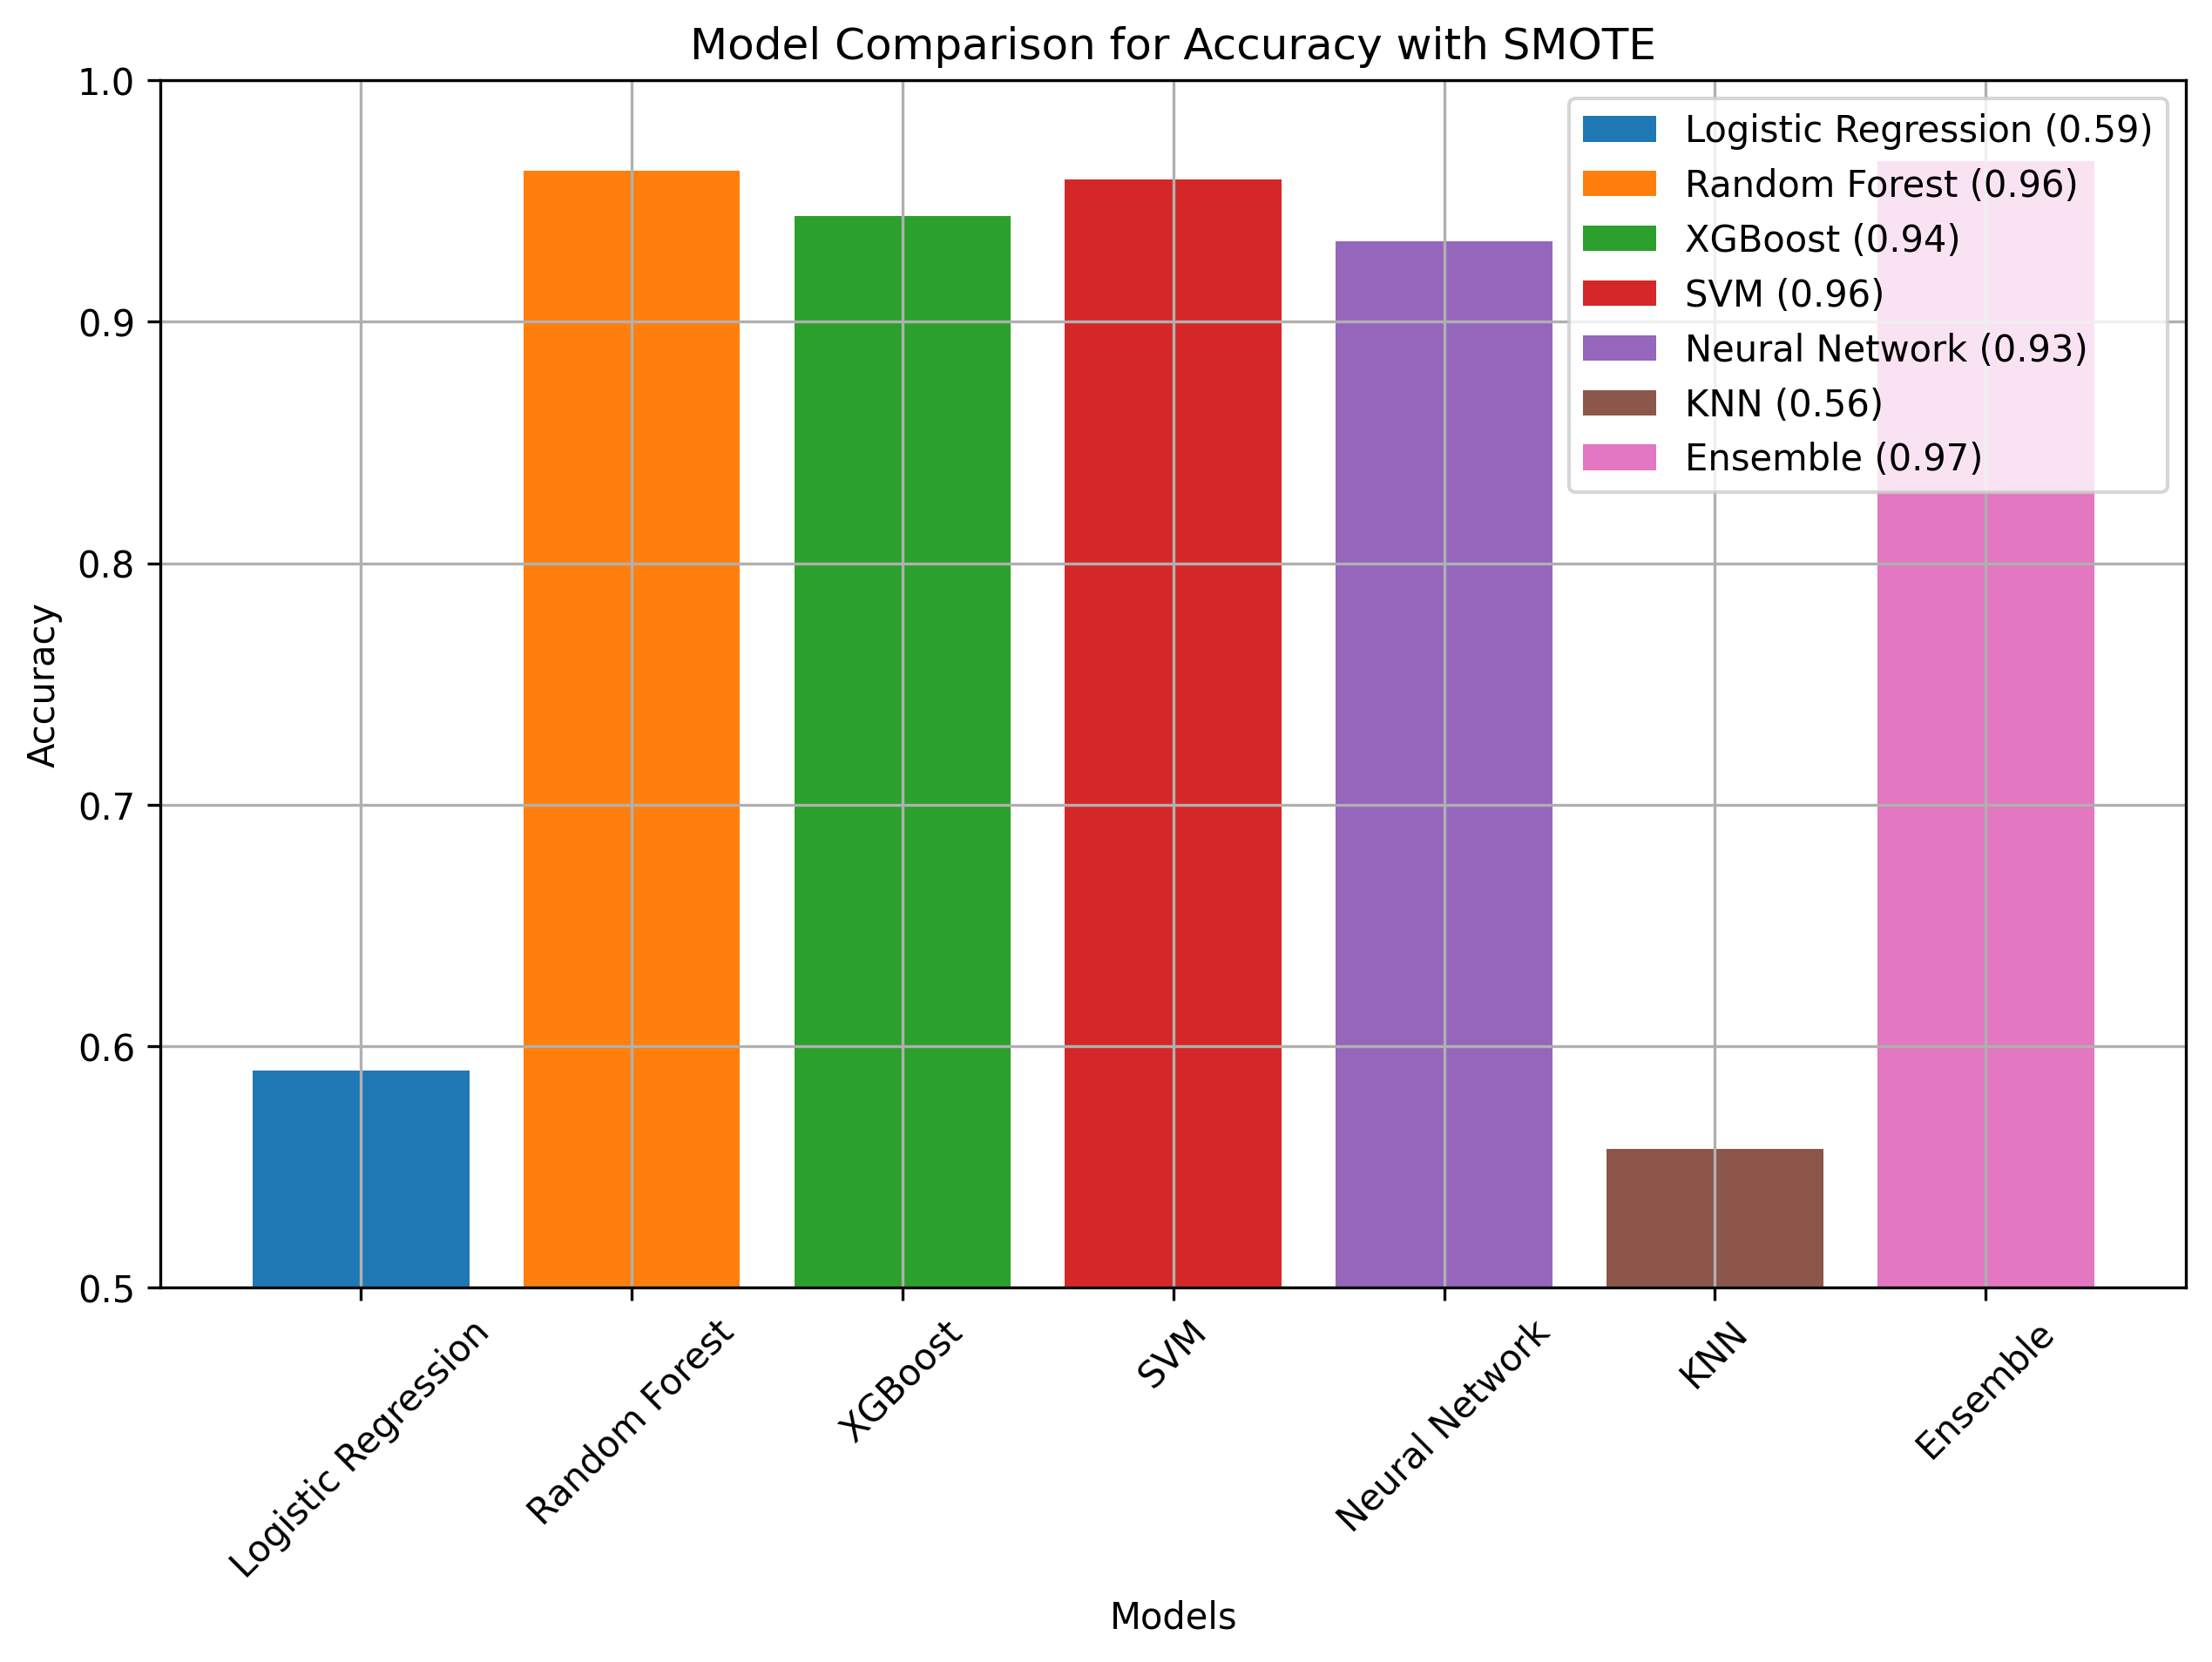

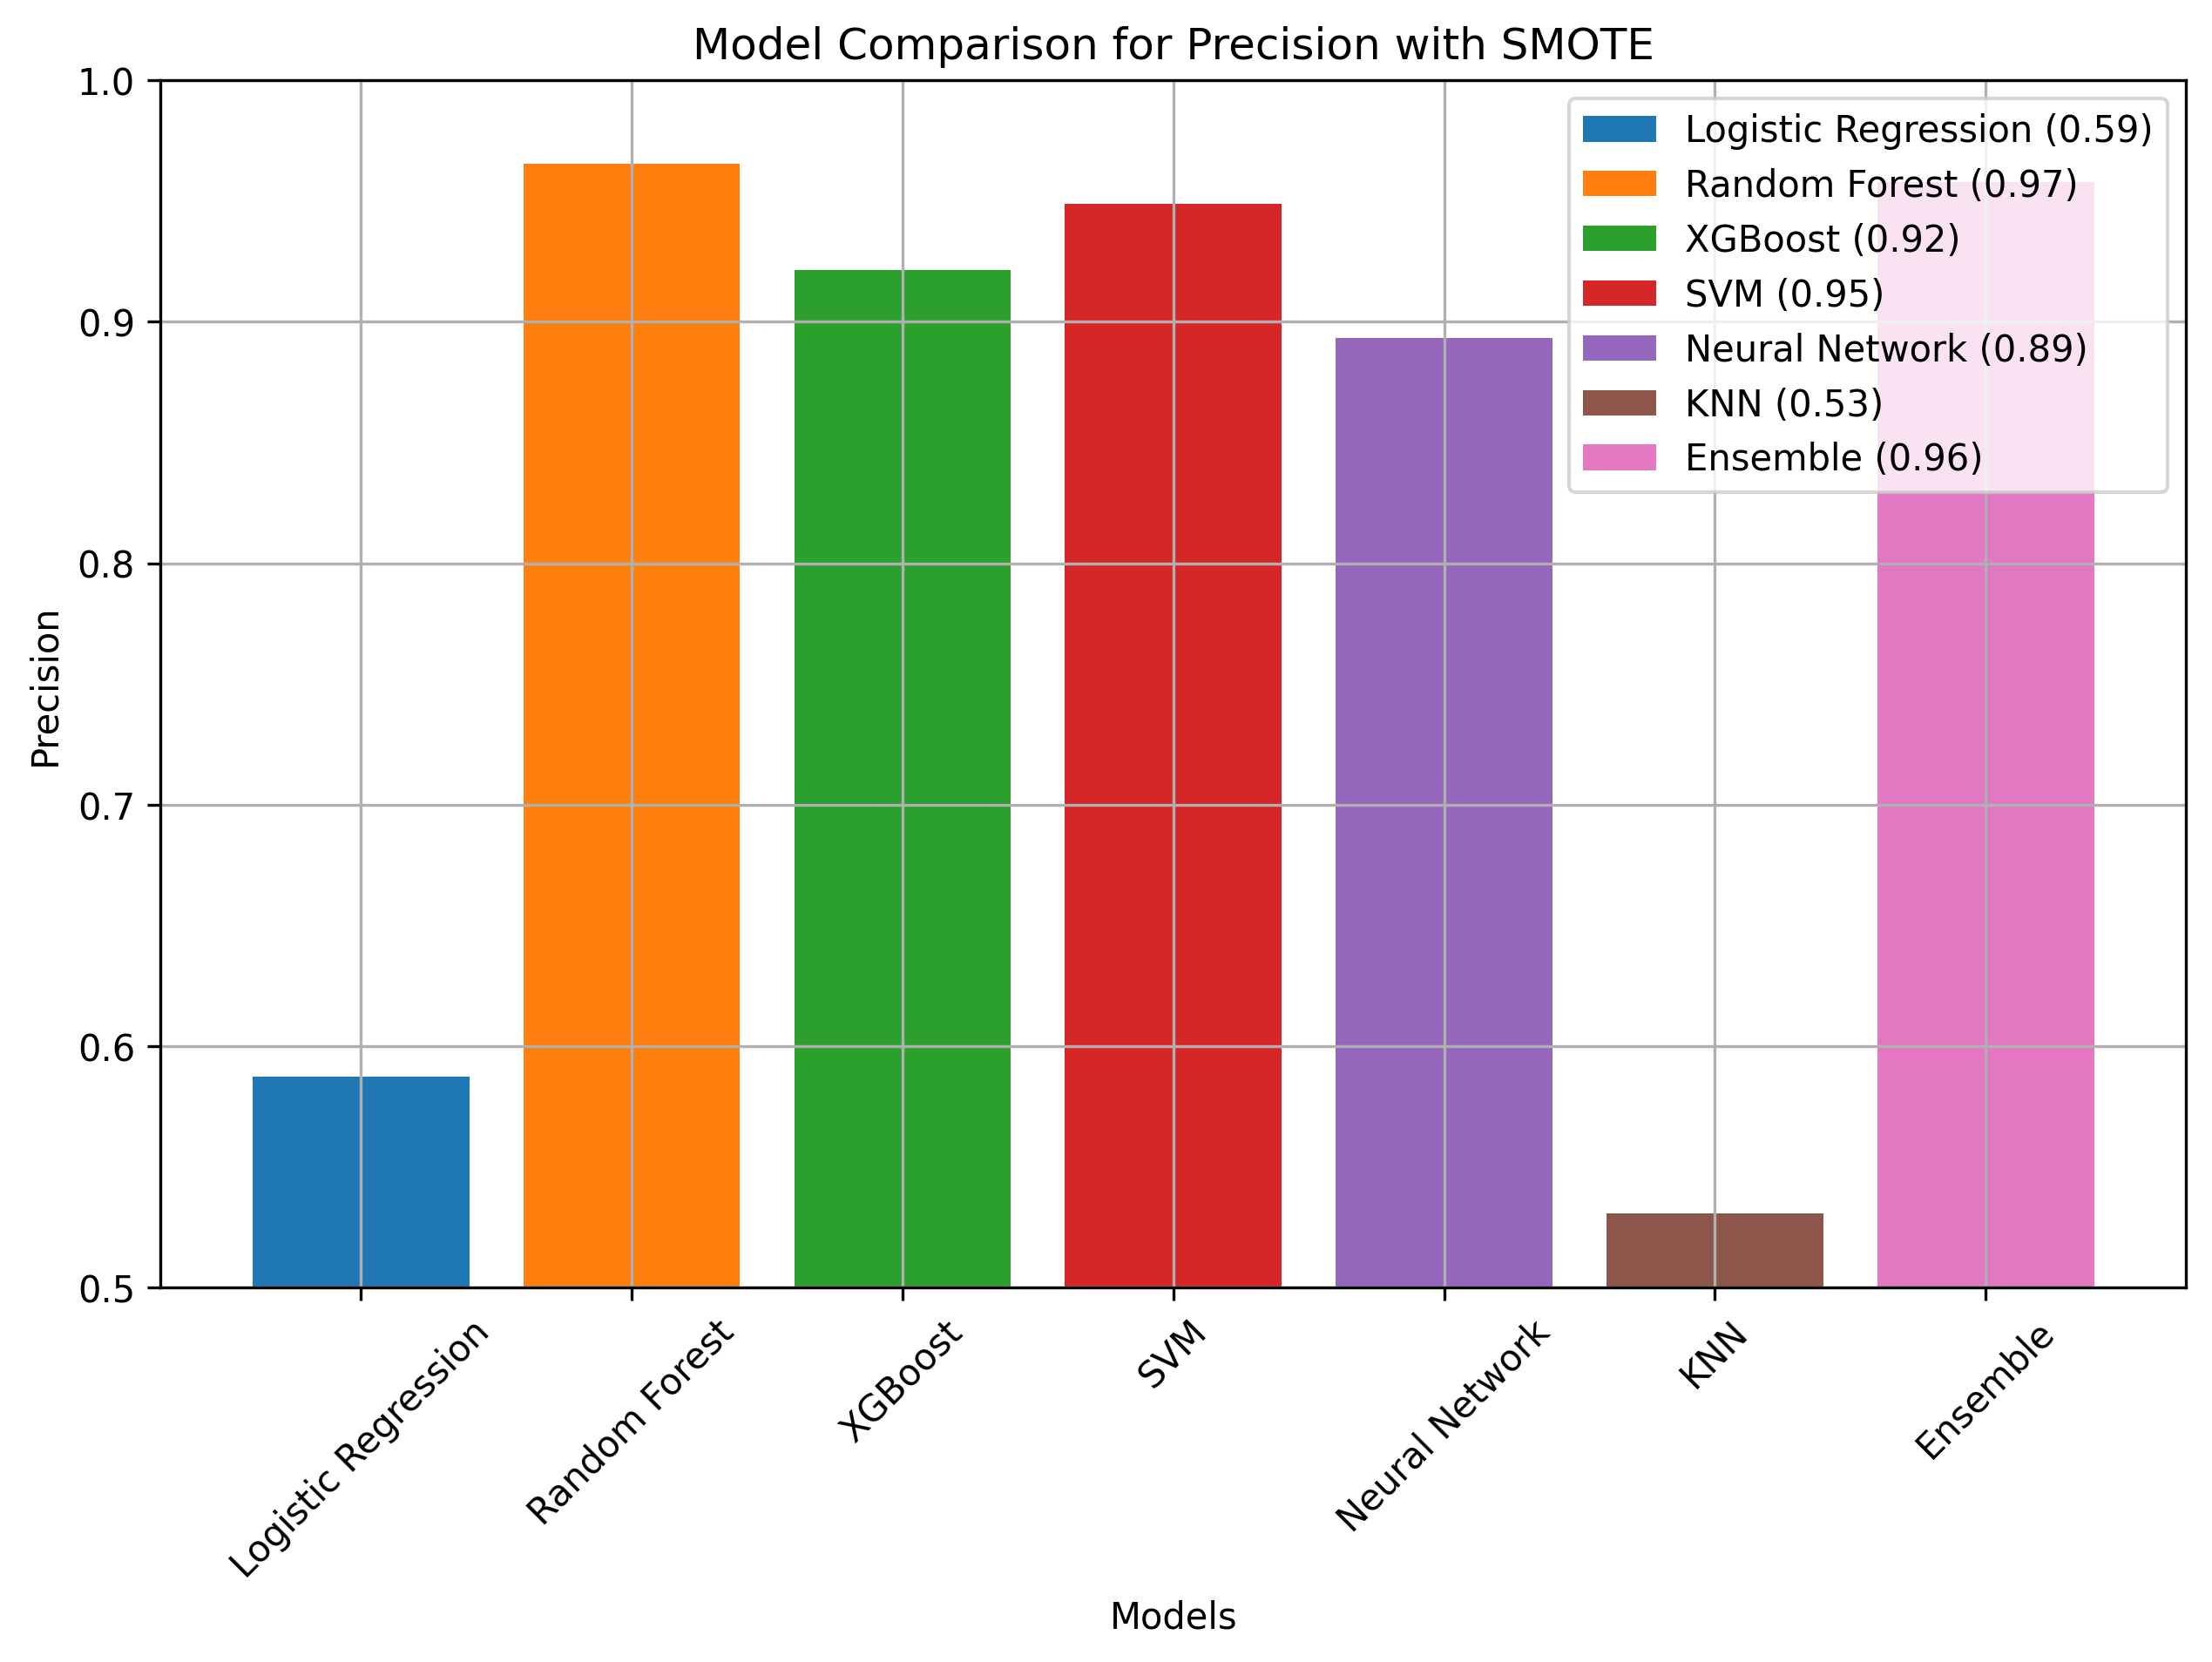

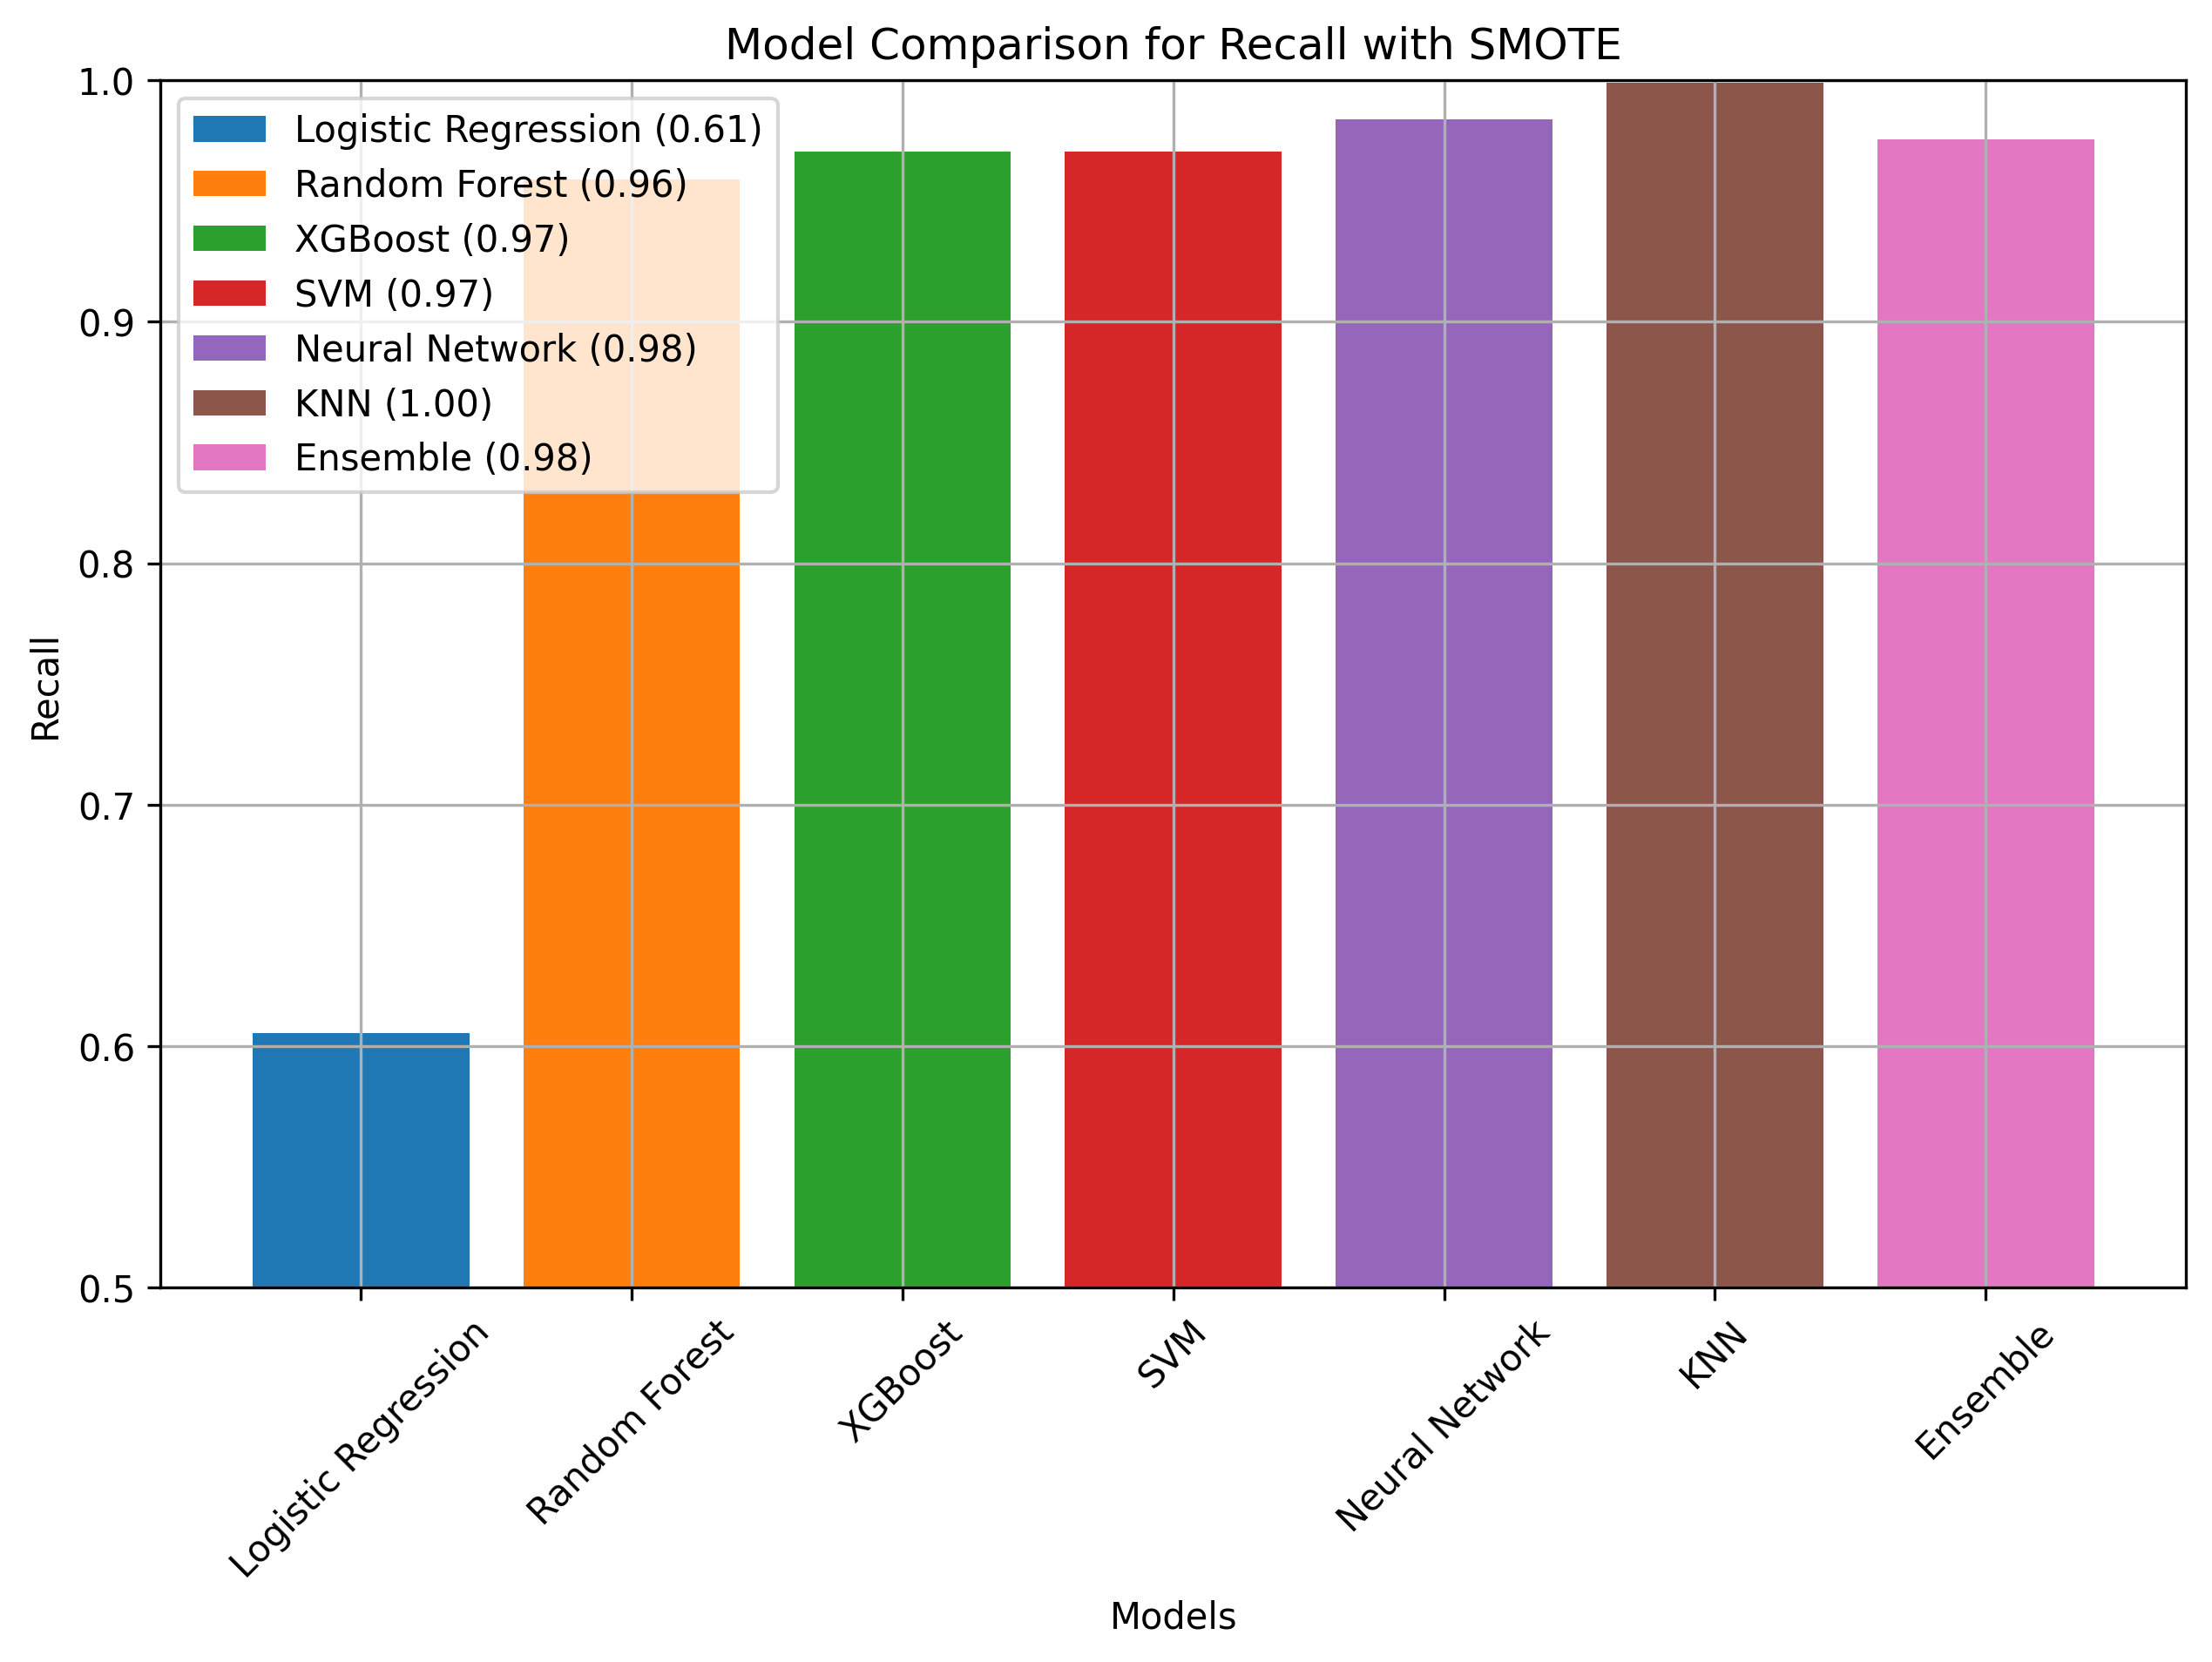

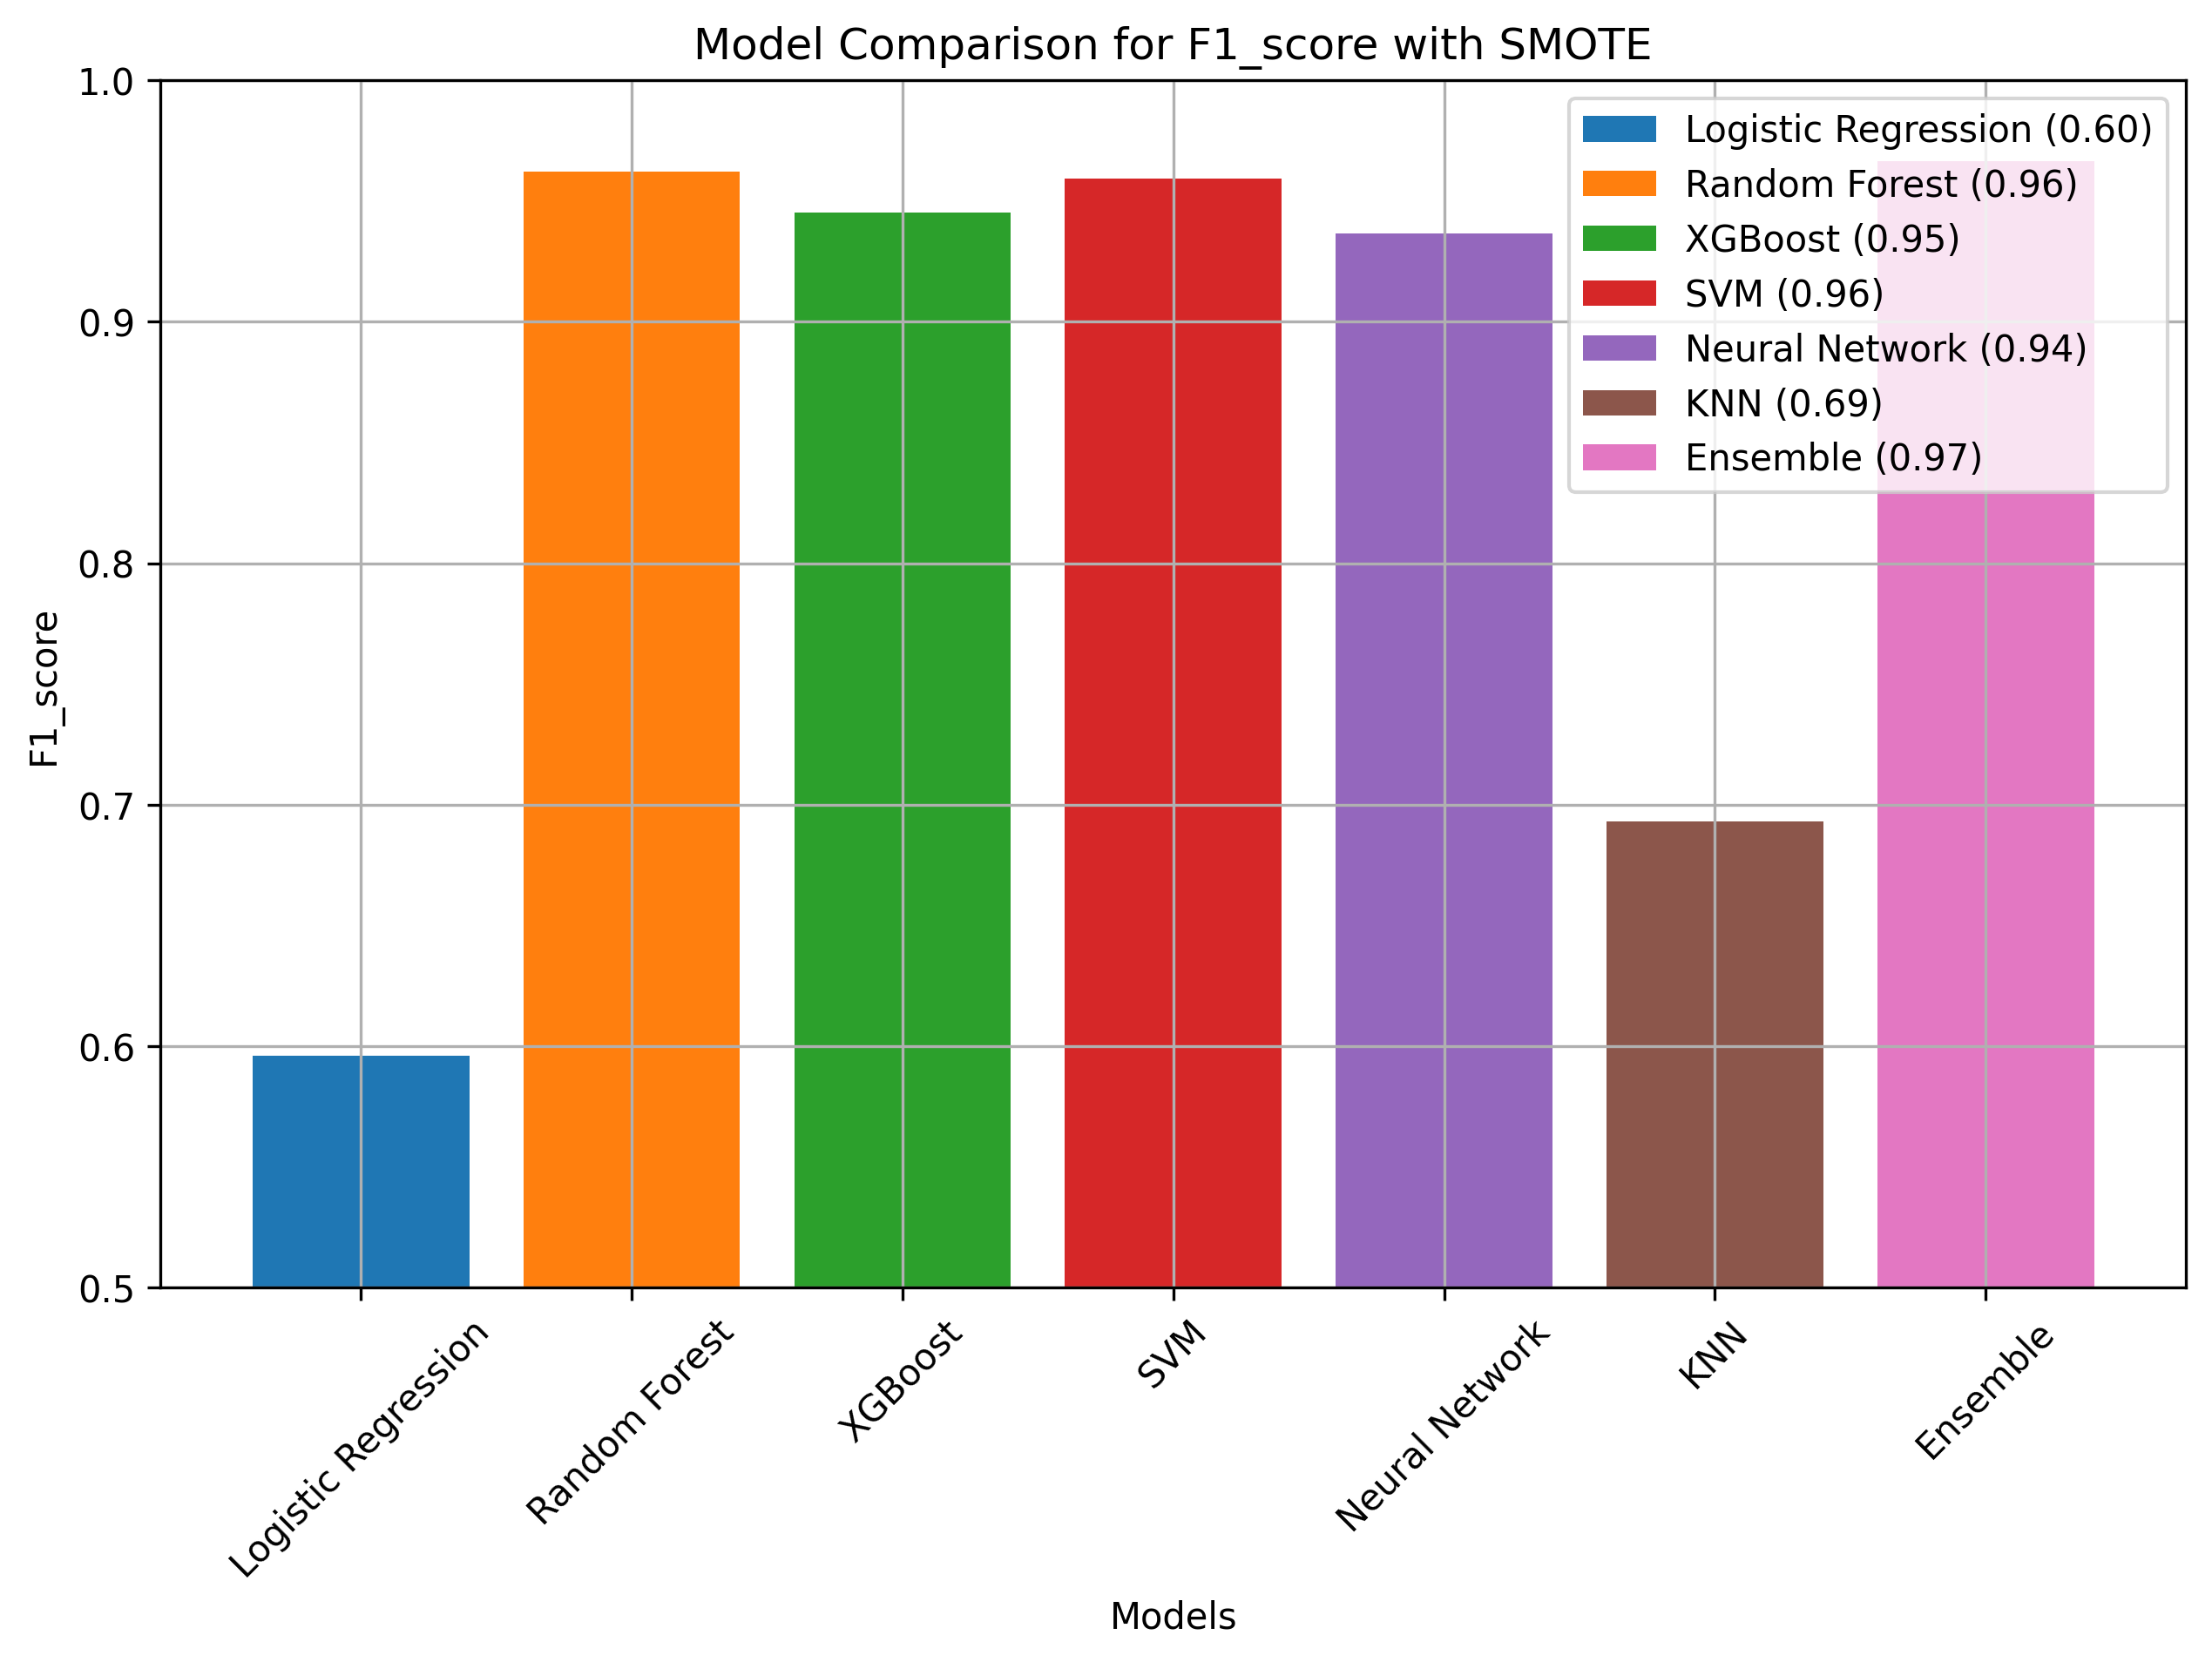

In [10]:
# Plotting the results
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics_names:
    plt.figure(figsize=(10, 6), dpi=300)
    plt.title(f'Model Comparison for {metric.capitalize()} with SMOTE')
    for name, metrics in results.items():
        plt.bar(name, metrics[metric], label=f'{name} ({metrics[metric]:.2f})')
    plt.xlabel('Models')
    plt.ylabel(metric.capitalize())
    plt.ylim(0.5, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

#### Main Observations and Conclusions

**SMOTE**:
- **Random Forest**, **SVM**, and **Ensemble** models performed the best with SMOTE, achieving high F1 scores.
- **XGBoost**, and **Neural Network** also performed well with SMOTE, showing high F1 scores.
- **Logistic Regression** and **KNN** models did not perform as well, indicating potential limitations in handling synthetic samples.

**Class Weight Adjustment**:
- Models generally performed worse with class weight adjustment compared to SMOTE.
- **Logistic Regression**, **SVM**, **Neural Network**, and **KNN** showed low F1 scores, indicating poor handling of class imbalance.
- **Random Forest**, **XGBoost**, and **Ensemble** models exhibited a strange situation where the F1 score is 0 despite a high precision of 1. This likely occurred because recall was 0, meaning the model did not correctly identify any positive samples.

**Conclusions**:
- **SMOTE** appears to be more effective than class weight adjustment for handling class imbalance in this dataset.
- The **Random Forest**, **SVM**, and **Ensemble** models, in particular, benefit the most from SMOTE, showing the highest performance metrics.

Based on these observations, SMOTE is the preferred method for addressing class imbalance. We will take the **Random Forest**, **SVM**, and **Ensemble** models further for the analysis.

### 7. Hyperparameter Tuning and Evaluation

We will initialize the selected models (**Random Forest**, **SVM**, and **Ensemble**), define their hyperparameter grids for tuning, and evaluate their performance using SMOTE to handle class imbalance. The evaluation will be performed using cross-validation, and the best hyperparameters for each model will be identified using `RandomizedSearchCV`. Additionally, we will record the training time for each model to understand their computational efficiency.

In [12]:
# Initialize models to be used
def initialize_models():
    # Define and return the models to be used
    return {
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42),
        'Ensemble': VotingClassifier(estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
            ('svm', SVC(random_state=42))
        ], voting='hard')
    }

# Define the hyperparameter grids for the models
def get_param_grids():
    # Define hyperparameter grid for Random Forest
    param_grid_rf = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    # Define hyperparameter grid for SVM
    param_grid_svm = {
        'C': [1, 10, 100],
        'gamma': ['scale', 'auto', 0.1],
        'kernel': ['rbf', 'linear']
    }
    # Define hyperparameter grid for Ensemble model
    param_grid_ensemble = {
        'rf__n_estimators': [50, 100, 350],
        'xgb__n_estimators': [50, 100, 350],
        'svm__C': [1, 10, 20]
    }
    # Return the parameter grids
    return {
        'Random Forest': param_grid_rf,
        'SVM': param_grid_svm,
        'Ensemble': param_grid_ensemble
    }

# Format the metrics for better readability
def format_metrics(metrics):
    return {k: f"{v:.5f}" for k, v in metrics.items()}

# Evaluate the models with hyperparameter tuning using RandomizedSearchCV
def evaluate_models(models, param_grids, X, y, smote, n_folds=5, n_iter_search=3):
    results = {}
    training_times = {}
    best_params = {}
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Apply SMOTE to handle class imbalance
        X_resampled, y_resampled = smote.fit_resample(X, y.values.ravel())

        # Perform hyperparameter tuning using RandomizedSearchCV
        random_search = RandomizedSearchCV(estimator=model, 
                                           param_distributions=param_grids[name], 
                                           n_iter=n_iter_search, 
                                           scoring='f1', 
                                           cv=skf, 
                                           verbose=0, 
                                           random_state=42, 
                                           n_jobs=-1)

        # Measure the time taken for training
        start_time = time.time()
        random_search.fit(X_resampled, y_resampled)
        elapsed_time = time.time() - start_time
        training_times[name] = elapsed_time / n_iter_search

        # Get the best model and evaluate its performance
        best_model = random_search.best_estimator_

        metrics = evaluate_model(best_model, X_resampled, y_resampled)
        results[name] = format_metrics(metrics)
        best_params[name] = random_search.best_params_

    return results, training_times, best_params

smote = SMOTE(random_state=42)  # Initialize SMOTE
models = initialize_models()  # Initialize models
param_grids = get_param_grids()  # Get parameter grids for models

# Evaluate models
print("Evaluating the models...")
results, training_times, best_params = evaluate_models(models, param_grids, train_data_scaled, train_labels_binary, smote)

# Display results
print()  # Adding an empty line before printing final metrics
for model_name, metrics in results.items():
    print(f"{model_name} - Metrics: {metrics}")

print("\nTraining times (seconds per run):")
for model_name, training_time in training_times.items():
    print(f"{model_name}: {training_time:.5f} seconds")

Evaluating the models...


C:\Users\35844\anaconda3\envs\alex_4\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest - Metrics: {'accuracy': '0.96681', 'precision': '0.97701', 'recall': '0.95614', 'f1_score': '0.96645'}
SVM - Metrics: {'accuracy': '0.97747', 'precision': '0.96115', 'recall': '0.99526', 'f1_score': '0.97789'}
Ensemble - Metrics: {'accuracy': '0.97673', 'precision': '0.97021', 'recall': '0.98370', 'f1_score': '0.97690'}

Training times (seconds per run):
Random Forest: 19.95639 seconds
SVM: 2.11338 seconds
Ensemble: 6.81657 seconds


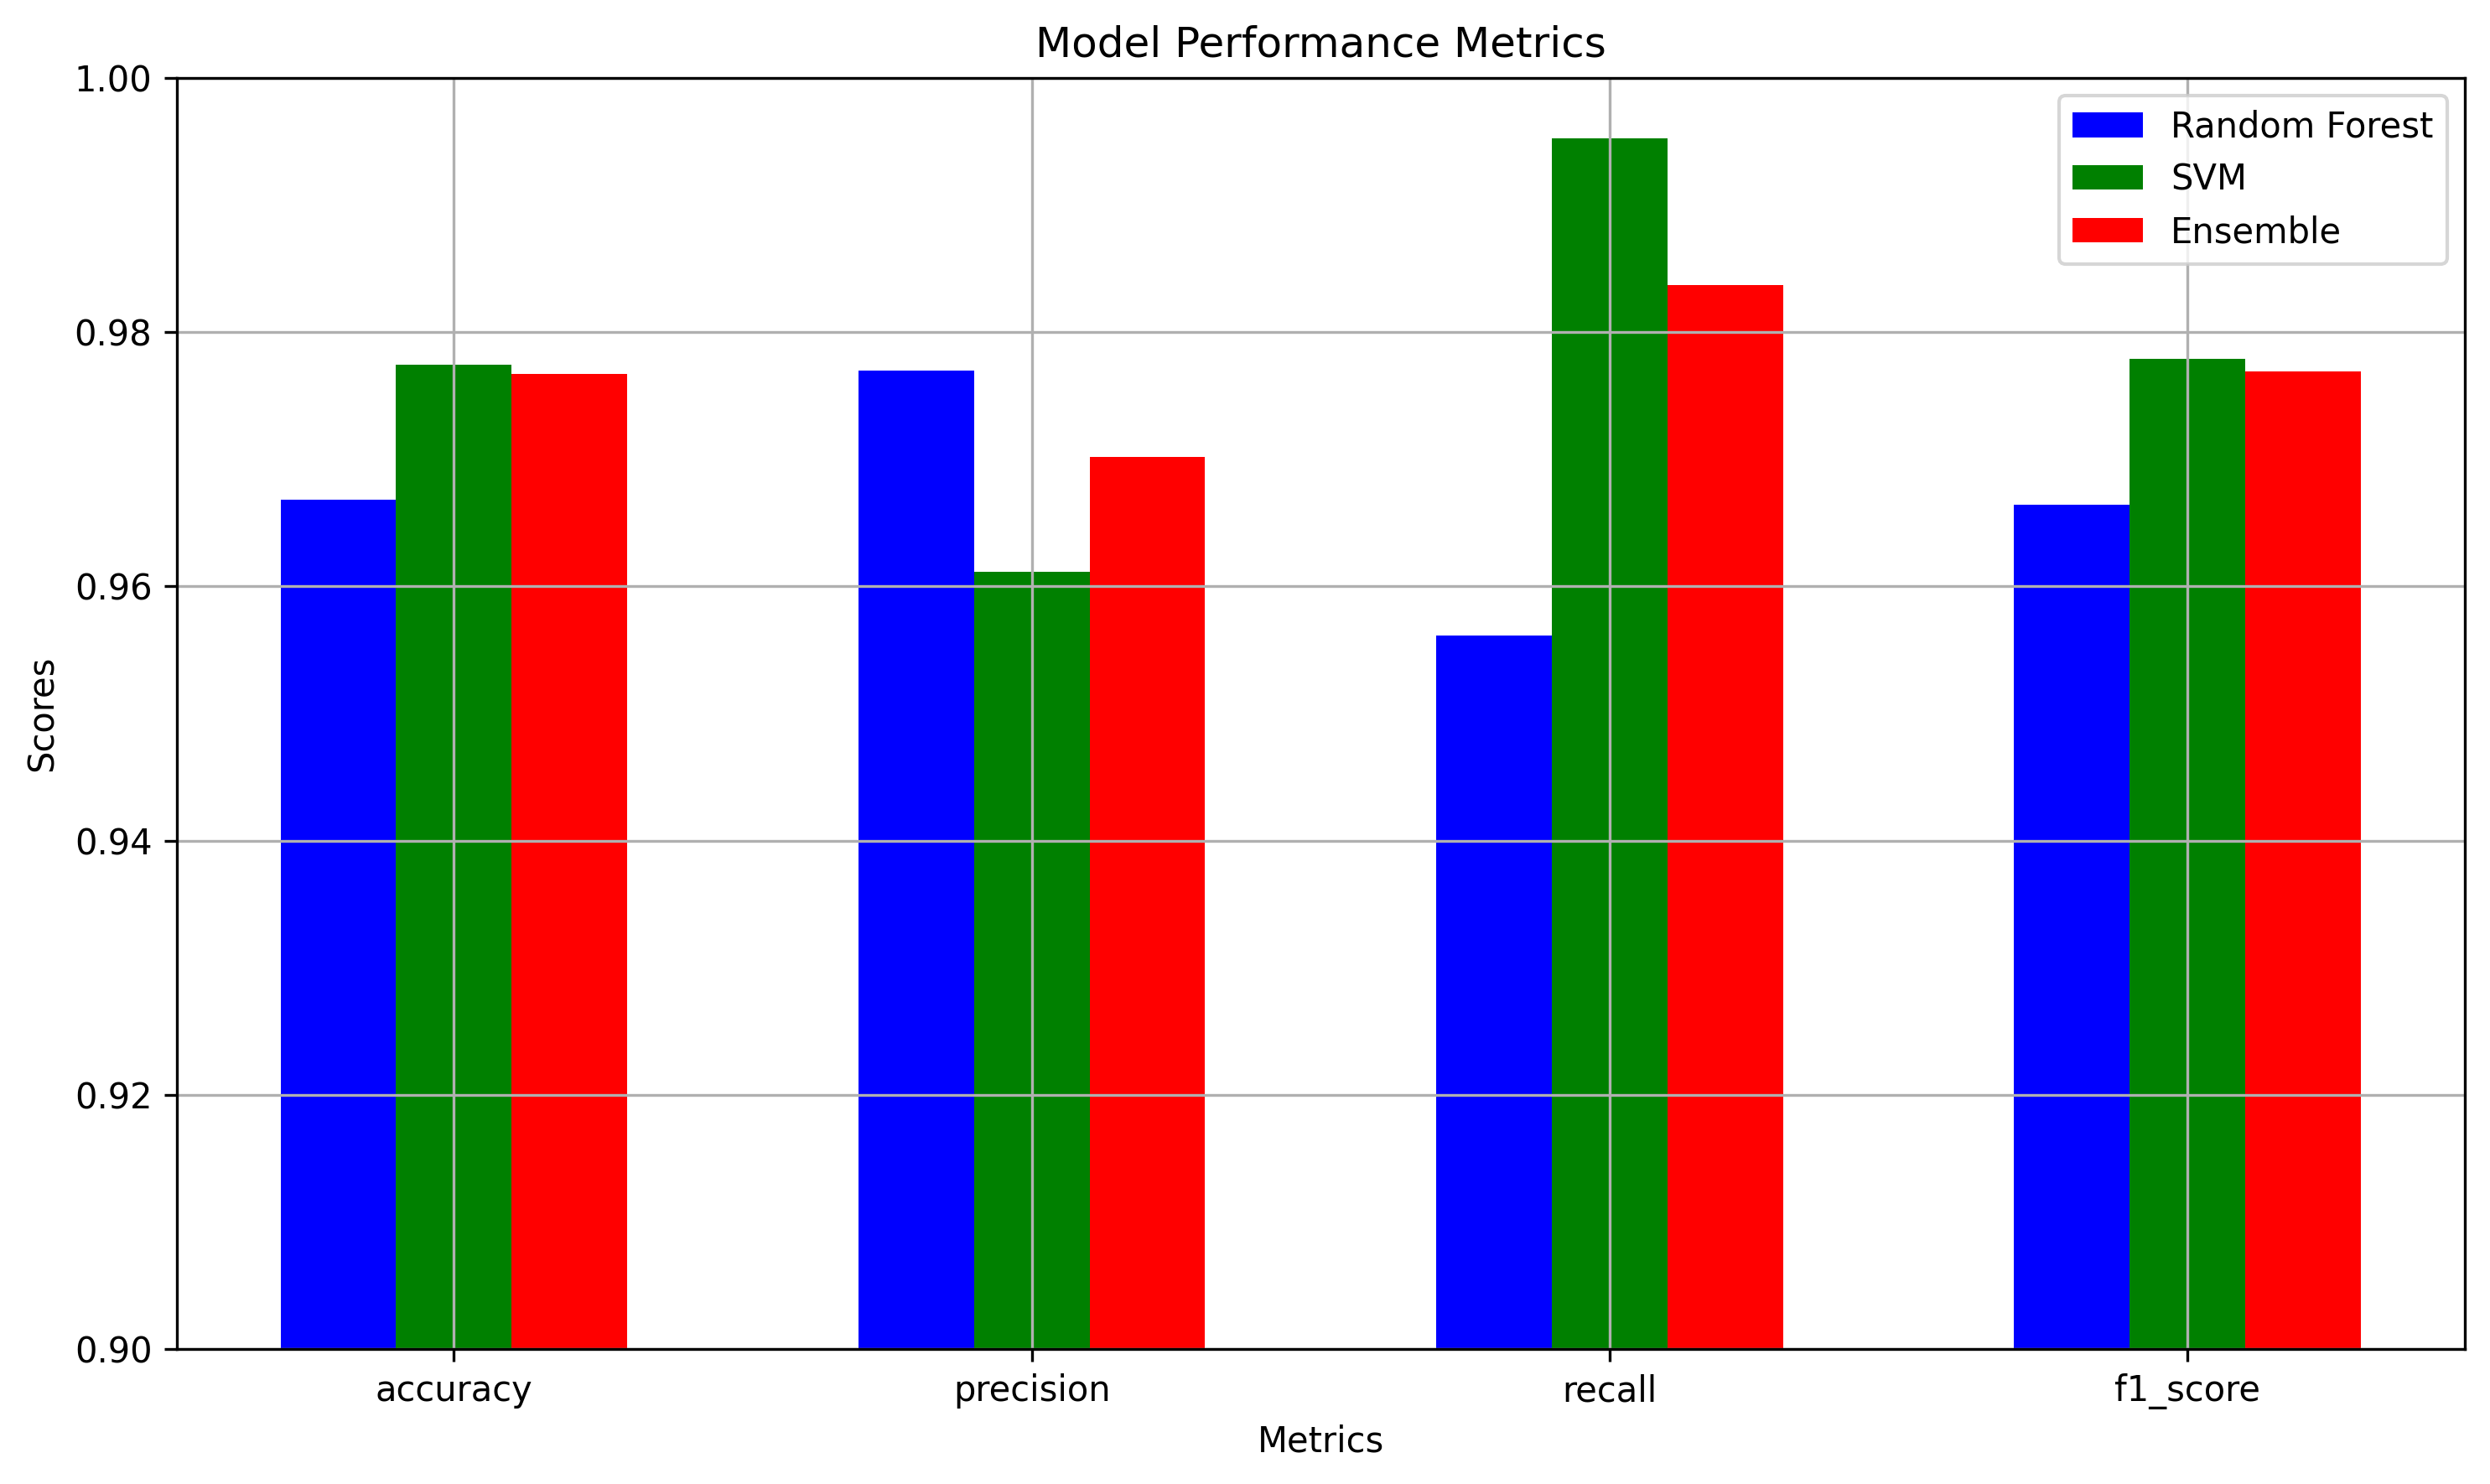

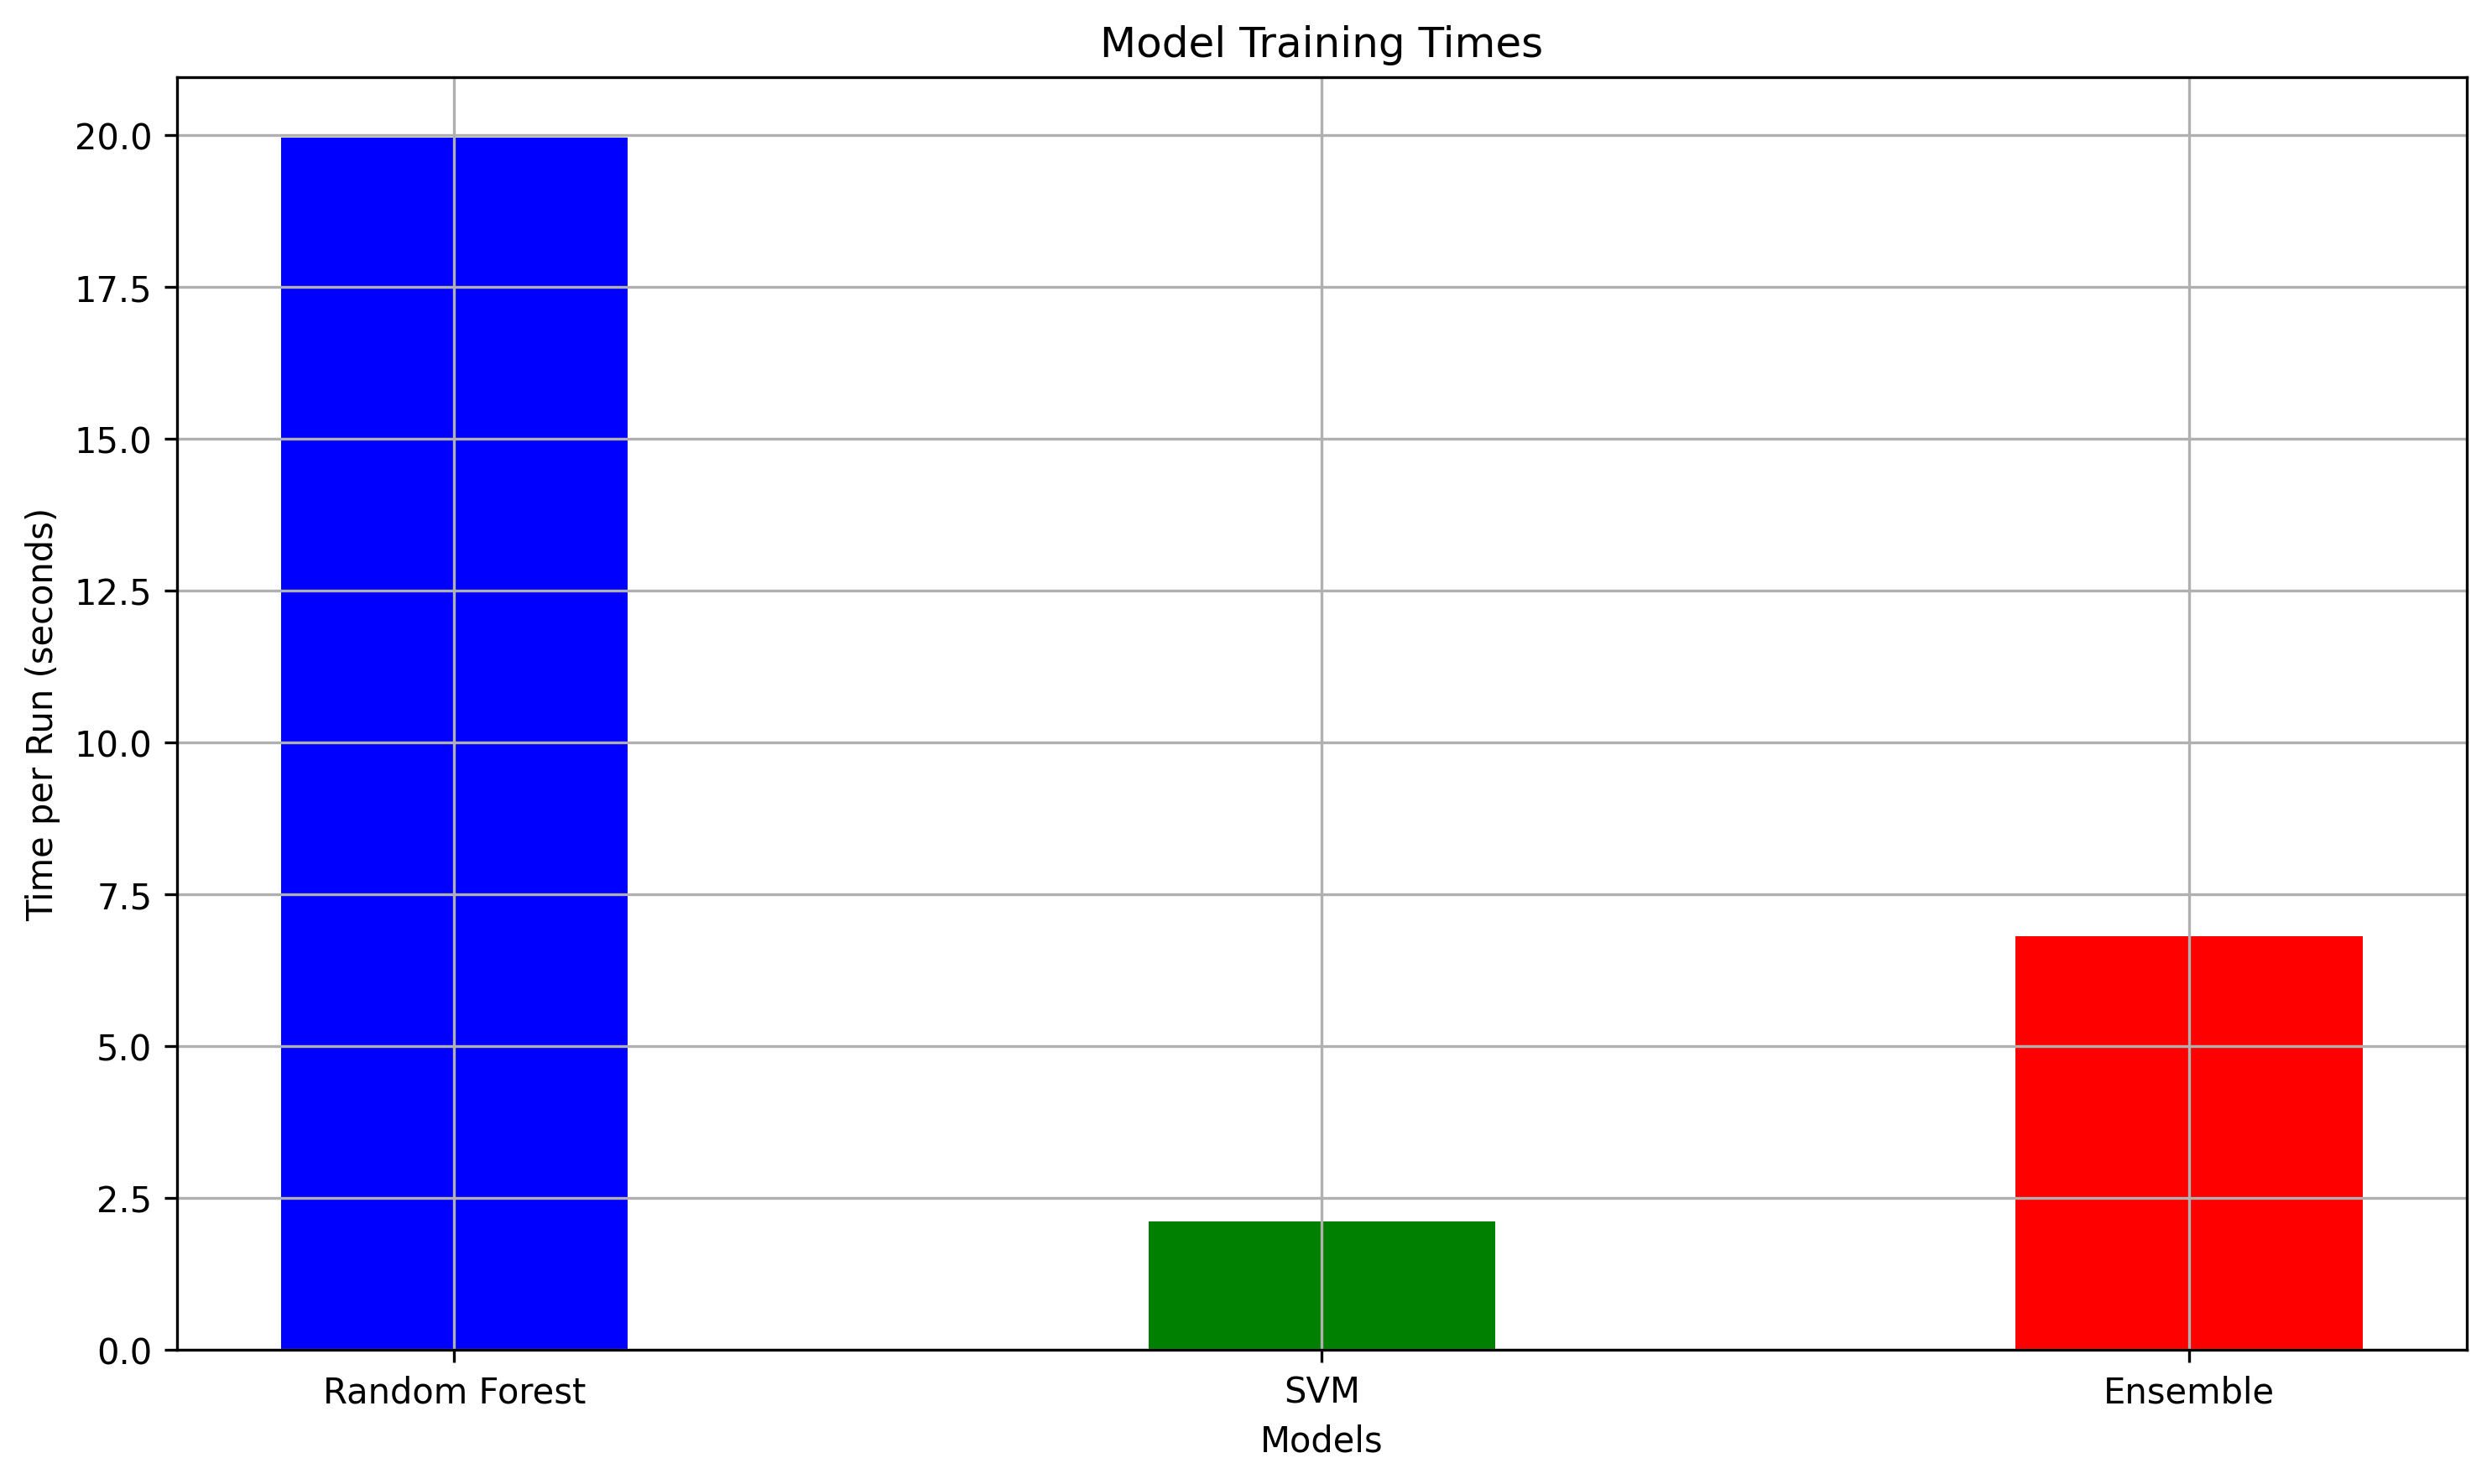

In [13]:
def plot_metrics(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    n_metrics = len(metrics)
    n_models = len(results)
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    bar_width = 0.2
    index = np.arange(n_metrics)
    colors = ['b', 'g', 'r']

    for i, (model_name, model_metrics) in enumerate(results.items()):
        values = [float(model_metrics[metric]) for metric in metrics]
        ax.bar(index + i * bar_width, values, bar_width, label=model_name, color=colors[i])

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_ylim(0.9, 1)
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(metrics)
    ax.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_training_times(training_times):
    models = list(training_times.keys())
    times = list(training_times.values())

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    bar_width = 0.4
    index = np.arange(len(models))
    colors = ['b', 'g', 'r']

    ax.bar(index, times, bar_width, color=colors[:len(models)])

    ax.set_xlabel('Models')
    ax.set_ylabel('Time per Run (seconds)')
    ax.set_title('Model Training Times')
    ax.set_xticks(index)
    ax.set_xticklabels(models)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Plot metrics and training times
plot_metrics(results)
plot_training_times(training_times)


The bar plots show the performance metrics (accuracy, precision, recall, and F1 score) for each model with the best hyperparameters found using SMOTE. Additionally, the training times per run for each model are displayed to understand the computational efficiency.

The performance metrics are plotted with a consistent color and style as previous plots, providing a clear comparison between the models.

**Justification for Selecting SVM**:
- The **SVM** model achieves the highest F1 score (0.9779) and accuracy (0.9775), which are critical metrics for evaluating the effectiveness of a model, especially in imbalanced datasets.
- Precision and recall are both high for the **SVM** model (0.9611 and 0.9953, respectively), indicating that the model is effective at identifying positive samples while minimizing false positives and false negatives.
- The training time for the **SVM** model is significantly lower compared to the **Random Forest** and **Ensemble** models. This efficiency is important for scalability and deploying the model in production environments where resources may be limited.
- The **SVM** model's ability to handle high-dimensional data and its robustness to overfitting make it a suitable choice for this dataset, which has a large number of features.

Based on these evaluations, the **SVM** model stands out as the best performer in terms of accuracy, F1 score, precision, and recall, while also being computationally efficient. Therefore, we will proceed with the **SVM** model for further analysis and potential deployment.


### 8. Final Model Training and Predictions

In this step, we apply SMOTE to the entire training data, train the SVM model on the resampled data, and generate predictions on the test data. The predictions are then converted back to the original label format (-1 and 1) and saved to a CSV file file named `test_labels.csv`. Finally, we calculate the label distribution in the test predictions to understand the model's output balance.

In [14]:
# Apply SMOTE to the entire training data
X_resampled, y_resampled = smote.fit_resample(train_data_scaled, train_labels_binary.values.ravel())

# Train the SVM model on the resampled data
best_model = SVC(kernel='rbf', gamma='auto', C=10, random_state=42)
best_model.fit(X_resampled, y_resampled)

# Generate predictions on the test data
test_predictions = best_model.predict(test_data_scaled)

# Convert predictions back to -1 and 1
test_predictions = np.where(test_predictions == 0, -1, 1)

# Save predictions to a CSV file
pd.DataFrame(test_predictions, columns=['label']).to_csv('test_labels.csv', index=False)

# Create a DataFrame for test predictions
test_predictions_df = pd.DataFrame(test_predictions, columns=['label'])

# Calculate label distribution
label_distribution = test_predictions_df['label'].value_counts()
print("Label distribution in test data:")
print(label_distribution)


Label distribution in test data:
 1    1246
-1       3
Name: label, dtype: int64


## Final Remarks

In this notebook, we have developed and evaluated a machine learning model to detect cyber attacks using a high-dimensional dataset. The process involved several critical steps, including data loading and preprocessing, exploratory data analysis, feature engineering, handling class imbalance, model training and hyperparameter tuning, and final model evaluation.

**Key Takeaways**:

- **Data Preprocessing and Normalization**: Ensured that all features contributed equally to the model by normalizing the data.
- **Exploratory Data Analysis (EDA)**: Helped us understand the distribution of labels and the variance explained by the features.
- **Feature Engineering**: Explored polynomial and interaction features, ultimately selecting the most effective feature set for the model.
- **Handling Class Imbalance**: Applied SMOTE and class weight adjustment to address class imbalance, with SMOTE proving to be more effective.
- **Model Training and Hyperparameter Tuning**: Conducted hyperparameter tuning using RandomizedSearchCV to identify the best-performing models.
- **Model Evaluation and Comparison**: Compared multiple models based on performance metrics and training times, with the SVM model emerging as the top performer.

**Conclusion**:
The SVM model, trained using SMOTE to handle class imbalance, demonstrated the highest accuracy and F1 score while maintaining computational efficiency. This makes it the most suitable model for detecting cyber attacks in this dataset. 

**Future Work**:
Future improvements could include:
- Exploring additional feature engineering techniques and advanced machine learning algorithms.
- Implementing real-time data processing and model deployment for continuous monitoring of cyber threats.
- Conducting further validation using more diverse datasets to enhance the model's generalizability.
- Investigating deep learning models, such as neural networks and recurrent neural networks (RNNs), which could capture more complex patterns in the data and potentially improve detection performance.
- Exploring state-of-the-art models like transformers and other SOTA architectures that have shown superior performance in various domains. These models could be adapted for cybersecurity tasks to further enhance detection capabilities.